# Objective Summary

##### Goal Statement

The core goal of this analysis is to identify the optimal machine learning model that can effectively match immigrant neighborhood preferences to the most ideal ward location recommendations across major 10 English cities; London, Liverpool, Leeds, Leicester, Manchester, Birmingham, Nottingham, Bristol, Sheffield and Newcastle upon Tyne.

##### Data Sources and Metrics

The input data for training recommendation algorithms is sourced from regulated goverment data portals and from crowdsourced domains. They contain area attributes like unemployment rates, ethnic diversity, rent and cost of living indices, as well as crime levels across wards. 

The target model evaluation metrics are low root mean squared error (RMSE), mean square error (MSE) and mean absolute error (MAE) indicating ability to accurately rank wards by preference fit.

##### Evaluation Objective

Through careful evaluation, the aim is to determine the most effective algorithm that can correctly personalize immigrant ward suggestions based on their provided area priorities. The winning model will be the model with the lowest reasonable value for error and will be integrated into the SettleIn application.

-------------------------------------------------------------------------------------------------------------------

## 1. Import Libraries

In [1]:
# For data manipulation and analysis
import pandas as pd

# For numerical operations and array handling
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data scaling and correction
from sklearn.preprocessing import MinMaxScaler

# K-Nearest Neighbors Classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# K-Nearest Neighbors Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

# XGBoost Regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Multi-Layer Perceptron (MLP) Regression
from sklearn.neural_network import MLPRegressor

# Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# Cosine Similarity and Truncated Singular Value Decomposition (SVD)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Additional libraries for learning curve
from sklearn.model_selection import learning_curve
import warnings

# Filter warnings
warnings.filterwarnings("ignore")

Libraries imported.

## 2. Data Preprocessing

##### Data Source and Preprocessing

The data utilized for training and evaluating ward recommendation models was collected from public government data portals, national statistics agency data, and crowdsourced data. Key ward-level attributes gathered encompass socioeconomic indicators like unemployment rate, ethnic population percentage, rental price index, cost of living index, as well as deprivation index.

As the data is sourced from regulated public agencies, it proved clean and consistent with no observable abnormalities. That said, most of the data was drawn from different pools with varying standardization practices thus requiring an overarching standardization scale. This light pretreatment will be worked on values obtained for the Indices of Multipled Deprivation (IMD), Crime Rate and Unemployment rate. 

In [239]:
# Loading preprocessed dataset
df = pd.read_csv('merged_data_10_city.csv')

In [240]:
# Checking dimensions, data types, and summary stats
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Name                             952 non-null    object 
 1   WardID                           952 non-null    float64
 2   White British                    952 non-null    float64
 3   Other White                      952 non-null    float64
 4   White Irish                      952 non-null    float64
 5   White Gypsy or Irish Traveller   952 non-null    float64
 6   Black African                    952 non-null    float64
 7   Black Caribbean                  952 non-null    float64
 8   Other Black                      952 non-null    float64
 9   Pakistani                        952 non-null    float64
 10  Chinese                          952 non-null    float64
 11  Indian                           952 non-null    float64
 12  Bangladeshi           

In [241]:
df['City'].unique()

array(['London', 'Liverpool', 'Manchester', 'Birmingham', 'Sheffield',
       'Leeds', 'Leicester', 'Nottingham', 'Bristol',
       'Newcastle Upon Tyne'], dtype=object)

In [242]:
df.shape

(952, 26)

In [243]:
df.head()

,Name,WardID,White British,Other White,White Irish,White Gypsy or Irish Traveller,Black African,Black Caribbean,Other Black,Pakistani,...,Mixed White and Black Caribbean,Mixed White and Black African,Other Mixed,Other Ethnic Group,Crime Rate (%),Unemployed (%),City,IMD (Average Score),COL Index,Rent Index
0,City of London,1.0,57.5,18.6,2.4,0.0,0.6,1.3,0.7,0.2,...,0.5,0.5,1.4,1.2,0.82,4.5,London,12.1,74.8,68.1
1,Abbey,2.0,2.0,13.3,0.7,0.3,3.5,17.9,2.5,20.2,...,1.0,1.8,1.5,2.3,0.29,14.5,London,32.7,74.8,68.1
2,Alibon,3.0,61.3,7.8,1.0,0.0,2.0,15.2,1.1,1.1,...,1.2,1.1,0.6,0.7,0.12,12.2,London,36.1,74.8,68.1
3,Becontree,4.0,50.6,7.2,0.9,0.1,3.3,13.0,1.4,5.4,...,1.7,1.2,0.9,1.1,0.15,13.8,London,31.7,74.8,68.1
4,Chadwell Heath,5.0,55.1,5.8,1.2,0.0,4.8,9.4,1.8,3.7,...,1.6,1.5,1.0,1.2,0.12,12.1,London,38.0,74.8,68.1


In [244]:
# Defining the cities of interest
cities_of_interest = ['London', 'Manchester', 'Liverpool']

ethnic_group_columns = [
    'White British', 'Other White', 'Black African', 'Black Caribbean', 
    'Pakistani', 'Chinese', 'Indian', 'Bangladeshi', 'Other Asian', 'Arab', 'Mixed White and Asian', 
    'Mixed White and Black Caribbean', 'Mixed White and Black African', 
    'Other Mixed', 'Other Ethnic Group'
]

# Filtering the DataFrame to include only rows where the city is NOT in the list of cities of interest
filtered_df = df[~df['City'].isin(cities_of_interest)]

# Calculating the total count for each row in the filtered DataFrame
total_count = filtered_df[ethnic_group_columns].sum(axis=1)

# Dividing each ethnic group count by the total count to get percentages
percentage_columns = filtered_df[ethnic_group_columns].div(total_count, axis=0) * 100

# Replacing the original count values with the calculated percentages in the original DataFrame
df.loc[filtered_df.index, ethnic_group_columns] = percentage_columns

In [245]:
# Display the updated "df" DataFrame with normalized values
df[df['City'] == 'Newcastle Upon Tyne'].head()

,Name,WardID,White British,Other White,White Irish,White Gypsy or Irish Traveller,Black African,Black Caribbean,Other Black,Pakistani,...,Mixed White and Black Caribbean,Mixed White and Black African,Other Mixed,Other Ethnic Group,Crime Rate (%),Unemployed (%),City,IMD (Average Score),COL Index,Rent Index
926,Arthur's Hill,927.0,45.439137,7.265023,87.0,22.0,7.758089,0.184900,49.0,7.080123,...,0.508475,0.423729,1.302003,4.506934,76.1,3.7,Newcastle Upon Tyne,33.9,70.5,30.4
927,Benwell & Scotswood,928.0,76.516924,4.351895,36.0,48.0,2.838871,0.148183,69.0,2.979254,...,0.296366,0.397754,0.491343,1.739198,138.9,3.5,Newcastle Upon Tyne,41.3,70.5,30.4
928,Blakelaw,929.0,74.694420,5.535872,32.0,8.0,4.402126,0.070859,115.0,1.789194,...,0.150576,0.504872,0.398583,2.054916,136.1,3.9,Newcastle Upon Tyne,39.2,70.5,30.4
929,Byker,930.0,71.850660,7.170674,45.0,8.0,9.888249,0.126990,125.0,0.702675,...,0.406366,1.236031,1.464612,1.617000,349.7,5.1,Newcastle Upon Tyne,45.9,70.5,30.4
930,Callerton & Throckley,931.0,92.148800,1.549201,36.0,3.0,0.726786,0.028689,13.0,0.803290,...,0.306015,0.172133,0.325141,0.344267,125.9,2.5,Newcastle Upon Tyne,16.3,70.5,30.4


In [247]:
# Selecting only the rows where the city is in the list of cities of interest
cities_of_interest = ['London', 'Manchester', 'Liverpool', 'Birmingham', 'Sheffield', 'Leeds', 'Leicester', 'Nottingham', 'Bristol', 'Newcastle Upon Tyne']
filtered_df = df[df['City'].isin(cities_of_interest)]

# Extracting the crime rate column for scaling
crime_rate_values = filtered_df['Crime Rate (%)'].astype(float)

# Reshaping the data (required for MinMaxScaler)
crime_rate_values = crime_rate_values.values.reshape(-1, 1)

# Using Min-Max scaling to transform values between 0 and 100
scaler = MinMaxScaler(feature_range=(1, 100))
scaled_values = scaler.fit_transform(crime_rate_values)

# Updating the original DataFrame with scaled values
df.loc[filtered_df.index, 'Crime Rate (%)'] = scaled_values.flatten()

In [248]:
crime_rate_column = 'Crime Rate (%)'

# Create a MinMaxScaler with a custom feature range [0, 100]
scaler = MinMaxScaler(feature_range=(1, 100))

# Group by 'City' and scale the 'Crime Rate (%)' column within each group
for city, group in df.groupby('City'):
    indices = group.index
    scaled_values = scaler.fit_transform(group[[crime_rate_column]])
    df.loc[indices, crime_rate_column] = scaled_values.flatten()

In [249]:
df[df['Crime Rate (%)'] == 100]

,Name,WardID,White British,Other White,White Irish,White Gypsy or Irish Traveller,Black African,Black Caribbean,Other Black,Pakistani,...,Mixed White and Black Caribbean,Mixed White and Black African,Other Mixed,Other Ethnic Group,Crime Rate (%),Unemployed (%),City,IMD (Average Score),COL Index,Rent Index
624,West End,625.0,37.200000,28.300000,2.20,0.00,0.800000,2.500000,0.80,0.600000,...,0.700000,0.600000,2.200000,2.900000,100.0,6.0,London,20.60,74.8,68.1
636,City Center North,637.0,59.900000,11.700000,4.20,0.00,2.000000,0.300000,0.30,1.000000,...,1.100000,0.600000,1.500000,2.400000,100.0,64.6,Liverpool,17.40,45.4,25.0
705,Harpurhey,706.0,43.560000,7.150000,1.08,0.17,21.890000,1.260000,2.89,6.360000,...,1.890000,1.960000,1.000000,1.760000,100.0,5.5,Manchester,59.10,47.7,30.6
729,Bordesley & Highgate,730.0,13.999453,5.724251,134.00,11.00,17.925044,5.115579,255.00,20.387088,...,1.901245,0.998495,1.620845,4.944604,100.0,6.3,Birmingham,19.00,46.4,30.8
795,City (Sheffield),796.0,50.402410,8.269403,90.00,8.00,5.356050,0.800113,67.00,2.230903,...,1.058973,0.644797,1.073093,2.734504,100.0,2.0,Sheffield,10.00,44.8,25.9
856,Castle (Leicester),857.0,44.814831,11.746742,189.00,24.00,9.024044,2.167835,148.00,2.873242,...,1.557056,0.701105,1.281776,2.490430,100.0,2.7,Leicester,4.83,67.3,26.2
943,Monument,944.0,54.195909,10.489772,149.00,0.00,4.546812,0.365835,36.00,1.336419,...,0.530088,0.492758,1.082574,2.053158,100.0,2.6,Newcastle Upon Tyne,34.20,70.5,30.4


In [250]:
columns_to_scale = ['IMD (Average Score)', 'Unemployed (%)']

# Creating a MinMaxScaler with a custom feature range [0, 100]
scaler = MinMaxScaler(feature_range=(1, 100))

# Grouping by 'City' and scale the specified columns within each group
for column in columns_to_scale:
    for city, group in df.groupby('City'):
        indices = group.index
        scaled_values = scaler.fit_transform(group[[column]])
        df.loc[indices, column] = scaled_values.flatten()

In [251]:
df[df['Unemployed (%)'] == 100]

,Name,WardID,White British,Other White,White Irish,White Gypsy or Irish Traveller,Black African,Black Caribbean,Other Black,Pakistani,...,Mixed White and Black Caribbean,Mixed White and Black African,Other Mixed,Other Ethnic Group,Crime Rate (%),Unemployed (%),City,IMD (Average Score),COL Index,Rent Index
251,Northumberland Park,252.0,16.600000,20.700000,1.70,0.10,13.500000,22.000000,4.80,0.500000,...,2.700000,1.600000,2.100000,4.500000,15.487805,100.0,London,100.000000,74.8,68.1
704,Gorton & Abbey Hey,705.0,47.180000,6.710000,1.21,0.17,16.030000,2.260000,2.33,8.650000,...,2.200000,1.550000,1.180000,1.770000,73.600000,100.0,Manchester,75.879237,47.7,30.6
794,Burngreave,795.0,27.273086,5.266064,90.00,76.00,12.993570,2.465386,436.00,27.245474,...,1.684352,0.702142,1.573902,5.763086,34.206411,100.0,Sheffield,4.666667,44.8,25.9
830,Gipton & Harehills,831.0,24.919943,8.366832,204.00,197.00,13.292907,2.830960,631.00,23.840022,...,2.074675,0.797166,0.868706,4.980582,55.781065,100.0,Leeds,1.000000,45.4,27.5
859,Fosse,860.0,43.467391,21.965855,77.00,16.00,9.164940,1.564397,147.00,1.900136,...,1.785842,0.985785,1.164369,3.278806,25.615964,100.0,Leicester,31.947899,67.3,26.2
872,Aspley,873.0,58.415352,9.314345,85.00,16.00,8.956947,3.881894,481.00,4.063342,...,4.316270,0.775279,1.215154,2.221367,13.562141,100.0,Nottingham,1.000000,45.9,25.3
914,Lawrence Hill,915.0,33.562557,9.877925,176.00,19.00,26.883096,4.824351,577.00,5.890506,...,2.814649,1.082147,1.572578,3.598273,12.106198,100.0,Bristol,1.955368,52.7,37.9


In [252]:
df.to_csv('10merge.csv')

In [265]:
df = pd.read_csv('10merge.csv')

In [255]:
df.describe()

,WardID,White British,Other White,White Irish,White Gypsy or Irish Traveller,Black African,Black Caribbean,Other Black,Pakistani,Chinese,...,Mixed White and Asian,Mixed White and Black Caribbean,Mixed White and Black African,Other Mixed,Other Ethnic Group,Crime Rate (%),Unemployed (%),IMD (Average Score),COL Index,Rent Index
count,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,...,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,476.500000,50.946912,10.123537,40.517206,3.468992,4.232843,5.099861,36.100462,3.986261,1.536891,...,1.253191,1.568603,0.781192,1.377643,2.157236,13.350551,38.516968,43.898570,66.273424,54.658403
std,274.963028,24.730145,8.033274,90.148941,11.973157,4.316382,5.777155,92.107534,7.405172,1.512325,...,0.571183,1.029437,0.497509,0.683679,1.463381,14.743206,22.018131,24.729607,12.723544,18.729603
min,1.000000,0.100000,0.100000,0.000000,0.000000,0.096920,0.000000,0.000000,0.000000,0.050603,...,0.200000,0.064613,0.043076,0.075382,0.086151,1.000000,1.000000,1.000000,44.800000,25.000000
25%,238.750000,32.100000,4.000000,1.600000,0.000000,1.300000,1.200000,0.800000,0.600000,0.700000,...,0.900000,0.800000,0.400000,0.900000,1.084029,5.829268,19.828221,23.022044,47.700000,30.800000
50%,476.500000,50.950000,7.800000,2.600000,0.100000,2.711951,3.000000,2.200000,1.339430,1.172467,...,1.200000,1.300000,0.647091,1.300000,1.800000,8.985335,36.595749,42.167335,74.800000,68.100000
75%,714.250000,72.100000,14.800000,6.875000,0.400000,5.800000,6.700000,7.025000,3.821325,1.800000,...,1.527514,2.100000,1.000000,1.800000,2.900000,14.521951,54.450890,63.296593,74.800000,68.100000
max,952.000000,96.607797,55.900000,716.000000,197.000000,34.122339,38.200000,698.000000,64.238848,14.400000,...,5.300000,9.100000,2.800000,4.300000,11.600000,100.000000,100.000000,100.000000,74.800000,68.100000


## 3. Data Exploration

In [266]:
city_ward_counts = df.groupby('City')['WardID'].count()

city_ward_counts

City
Birmingham              69
Bristol                 34
Leeds                   33
Leicester               21
Liverpool               64
London                 625
Manchester              32
Newcastle Upon Tyne     26
Nottingham              20
Sheffield               28
Name: WardID, dtype: int64

In [268]:
# Defining a color palette for Seaborn plots
sns.set_palette("viridis")

In [269]:
# Filtering the data based on cities
selected_cities = ["Birmingham", "Bristol", "Leeds", "Leicester", "Liverpool", "London", "Manchester", "Newcastle Upon Tyne", "Nottingham", "Sheffield"]
selected_df = df[df['City'].isin(selected_cities)]

#### City-wise Comparison of Demographic Characteristics

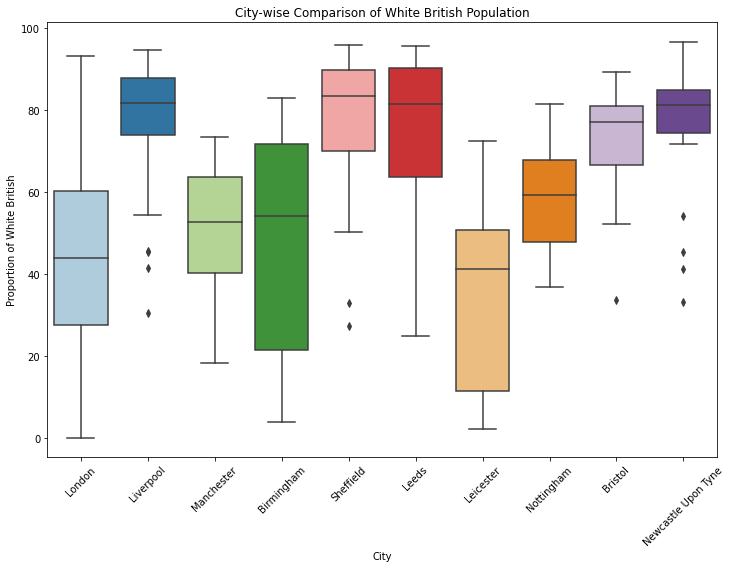

In [295]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='City', y='White British', data=selected_df)
plt.title('City-wise Comparison of White British Population')
plt.ylabel('Proportion of White British')
plt.xticks(rotation=45)
plt.show()

Visualisation shows considerable diversity in Birmingham, Leicester and London (evidently from the broader inter-quartile ranges or 'longer boxes'). Given the substantial populations of Birmingham and London, the extended interquartile ranges indicate a rich mix of ethnicities across wards, reflecting the presence of people from various cultural backgrounds. This diversity is particularly evident in the distributions of White British residents, which vary noticeably across different areas within these cities. In contrast, Newcastle and Liverpool exhibit narrower interquartile ranges, suggesting less diversity across wards. This pattern aligns with the smaller population sizes in these Northern England areas, implying potentially less ethnic diversity compared to their more populous counterparts in the South.

#### City-wise Comparison of Socio-economic Indicators

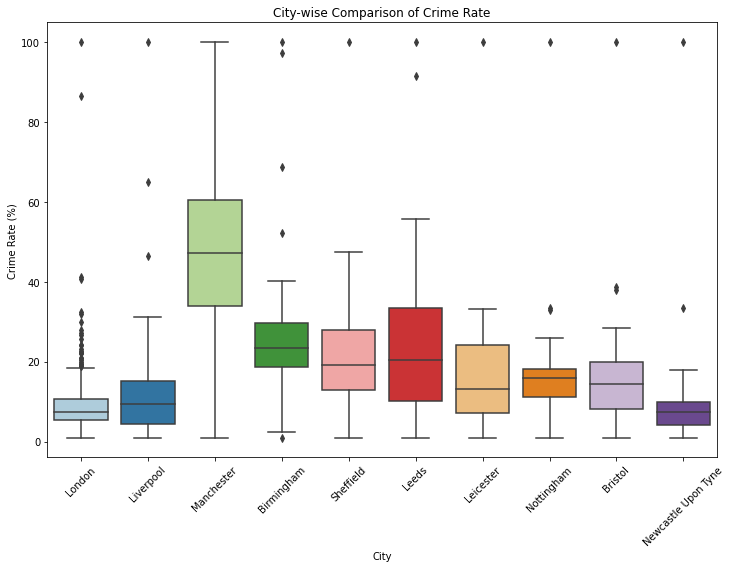

In [294]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='City', y='Crime Rate (%)', data=selected_df)
plt.title('City-wise Comparison of Crime Rate')
plt.ylabel('Crime Rate (%)')
plt.xticks(rotation=45)
plt.show()

Looking at the plot, we can see city-specific variations for crime. In Manchester and Leeds, longer boxes showing a broader range of crime rates, indicating diverse neighborhood safety levels. Meanwhile, London's shorter boxes highlight a more concentrated spread, yet the presence of numerous outliers suggests distinct pockets of both high and low crime across the city. Newcastle, with shorter boxes, hints at a more homogenous distribution of crime rates, correlating with its smaller population size in Northern England.

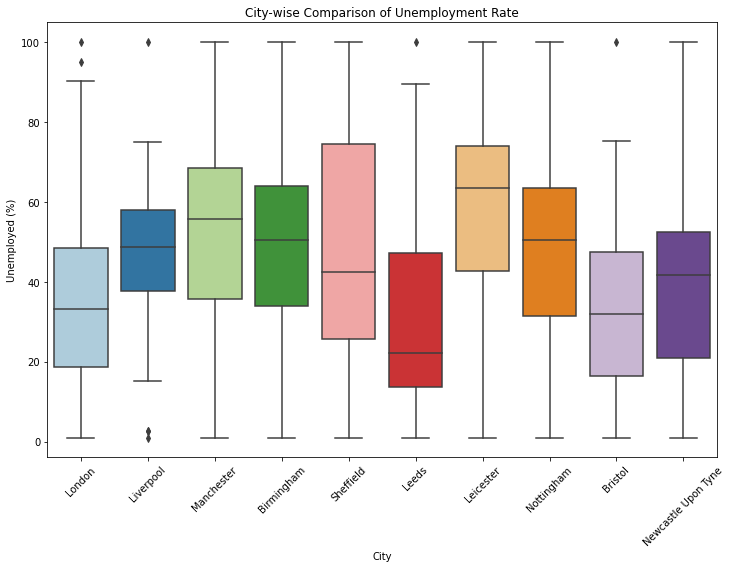

In [293]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='City', y='Unemployed (%)', data=selected_df)
plt.title('City-wise Comparison of Unemployment Rate')
plt.ylabel('Unemployed (%)')
plt.xticks(rotation=45)
plt.show()

The visual narrative of unemployment boxplots is seen with Sheffield, Leeds, and Bristol revealing substantial fluctuations in unemployment rates. Across the cities, the longer boxes imply diverse employment landscapes. The differences in box lengths show the intricate patterns of unemployment, showcasing varied economic conditions and opportunities in different regions.

#### Distribution of IMD Scores and Living Costs across Cities

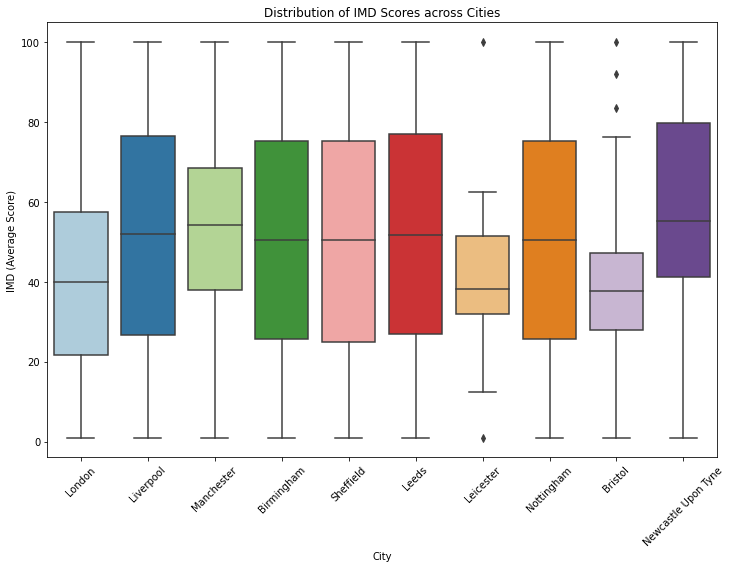

In [292]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='City', y='IMD (Average Score)', data=selected_df)
plt.title('Distribution of IMD Scores across Cities')
plt.ylabel('IMD (Average Score)')
plt.xticks(rotation=45)
plt.show()

Birmingham, Sheffield, Leeds, and Nottingham indicates a multifaceted distribution of deprivation levels while Bristol, Leicester, and Manchester shows a more uniform distribution of IMD scores, hinting at relatively consistent socio-economic conditions within these cities.

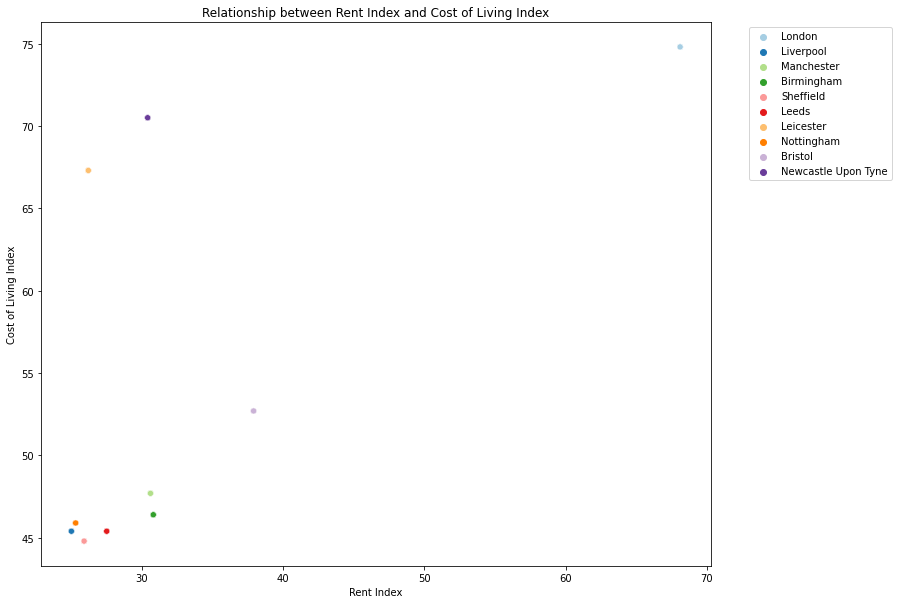

In [291]:
# Question 5: Relationship between Rent Index and Cost of Living Index
plt.figure(figsize=(12, 10))
sns.scatterplot(x='Rent Index', y='COL Index', hue='City', data=selected_df)
plt.title('Relationship between Rent Index and Cost of Living Index')
plt.xlabel('Rent Index')
plt.ylabel('Cost of Living Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

London, positioned in the top right corner with high rent and living costs, this is consistent with the current housing and cost of living crisis in the UK. Meanwhile, Sheffield, Liverpool, and Nottingham cluster in the low left corner, portraying cities with lower rent and living expenses. Leicester and Newcastle emerge as distinctive outliers, characterized by high COL indices and comparatively low rent indices.

#### Correlation between Ethnic Diversity and Socio-economic Indicators

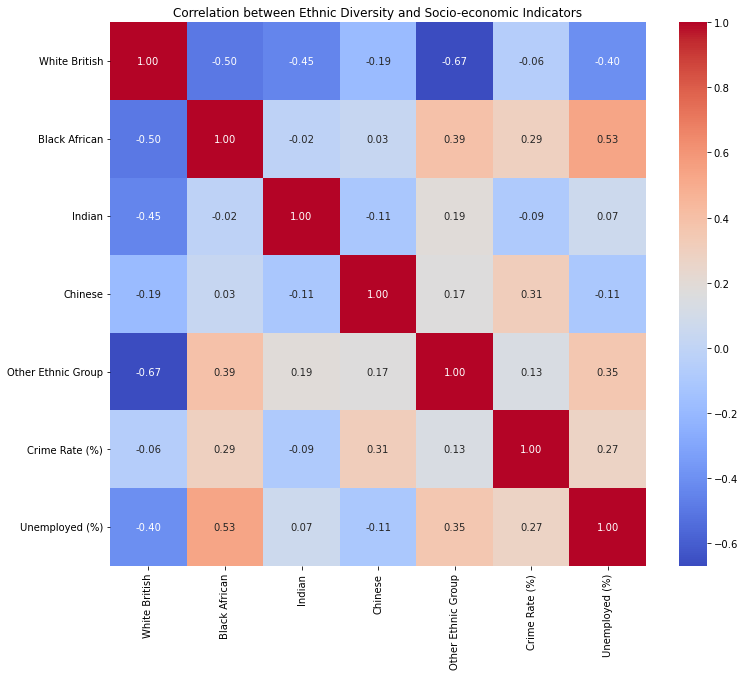

In [290]:
ethnicity_columns = ["White British", "Black African", "Indian", "Chinese", "Other Ethnic Group"]
corr_ethnic_socio = selected_df[ethnicity_columns + ["Crime Rate (%)", "Unemployed (%)"]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_ethnic_socio, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation between Ethnic Diversity and Socio-economic Indicators')
plt.show()

The correlation heatmap shows the intricate relationships between ethnic diversity by means of some distinct ethnic groups and possible socio-economic indicators. Positive correlations between unemployment rates and specific ethnic groups, such as Black Africans, shows potentially that more Black Africans are unemployed. Conversely, negative correlations between unemployment rates and White British individuals suggest the opposite for White British people. The positive correlations observed between crime rates and unemployment, particularly among Chinese and Black African populations, add depth to the narrative, hinting at potential socio-economic challenges for these ethnic groups

#### Summary Distribution Across Wards for Unemployment, Deprivation and Crime.

In [256]:
# List of cities
cities = df['City'].unique()

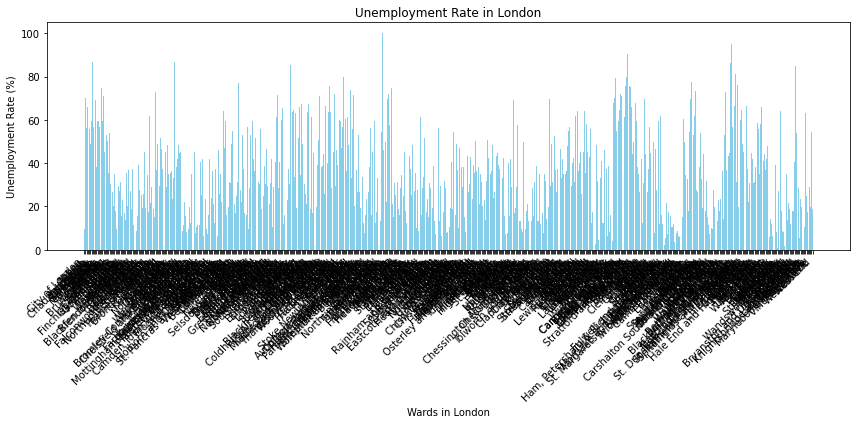

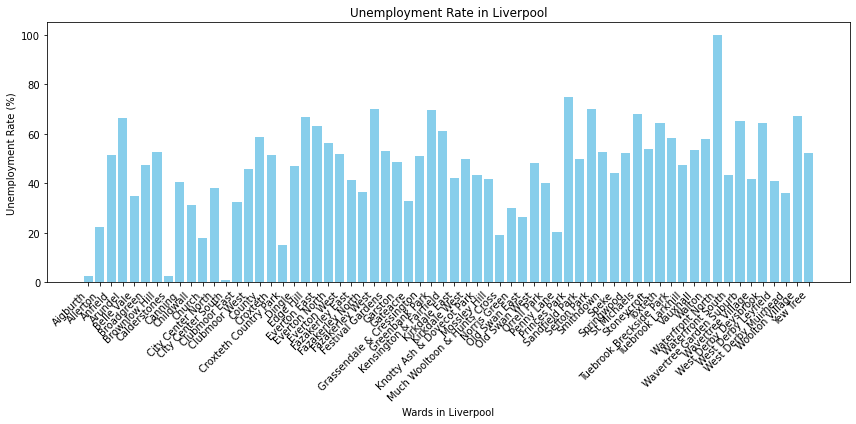

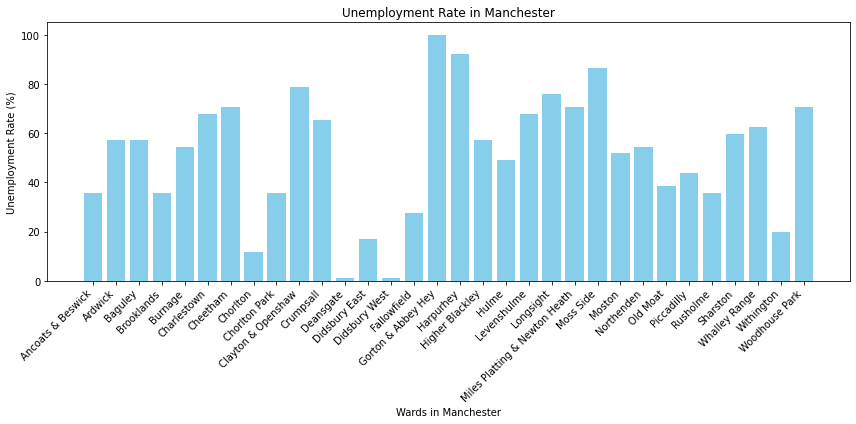

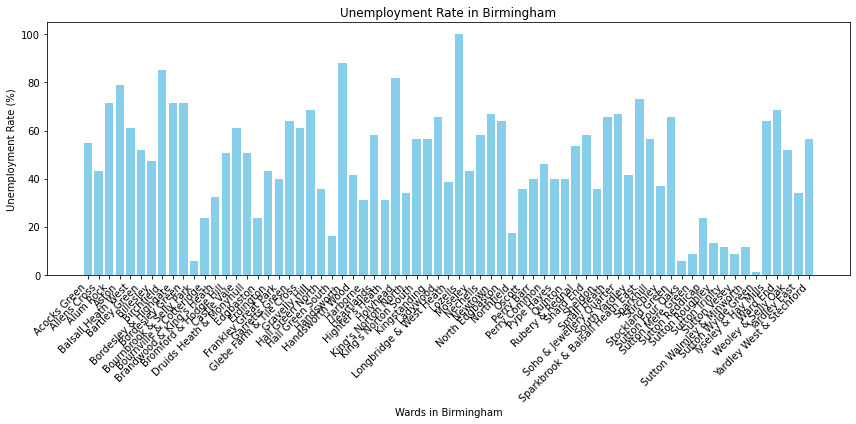

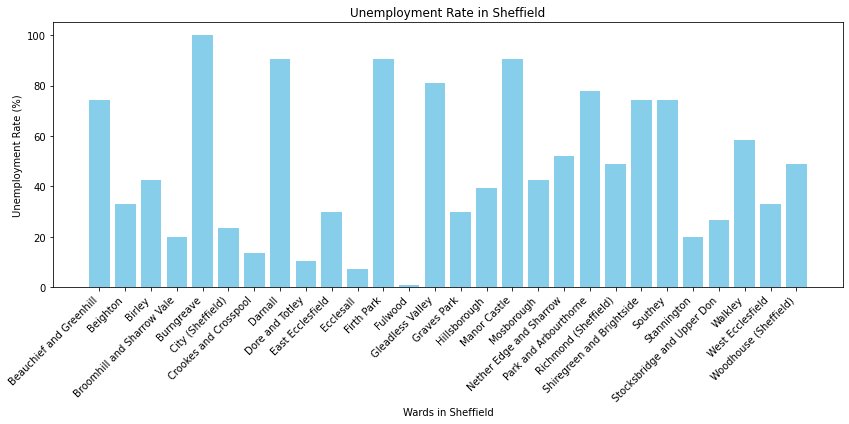

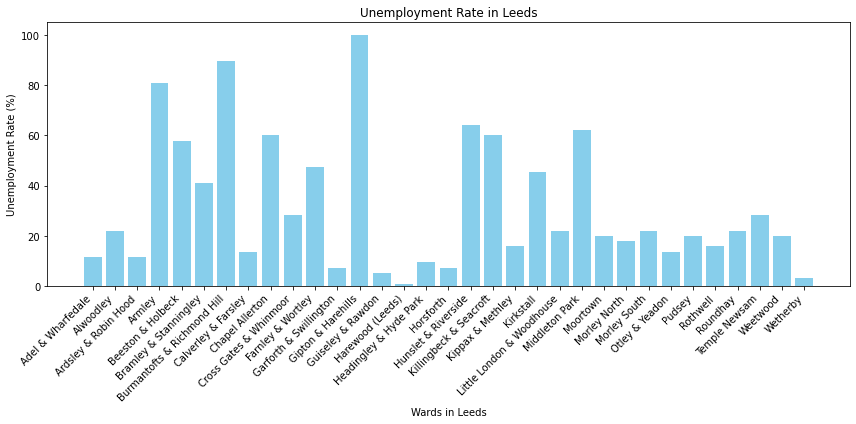

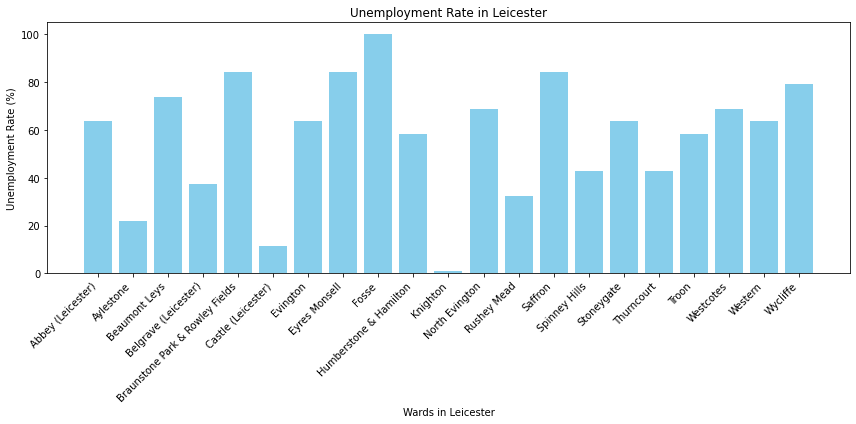

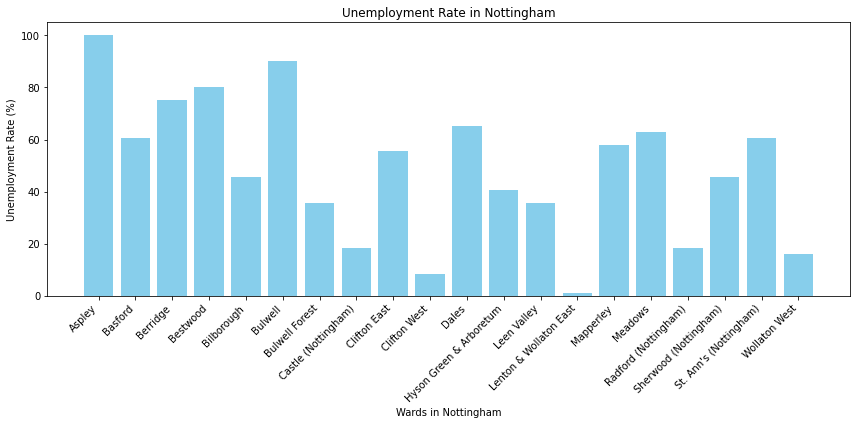

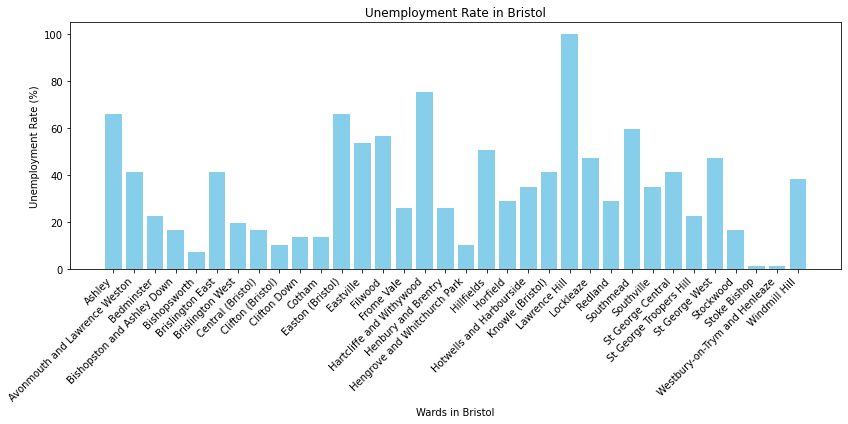

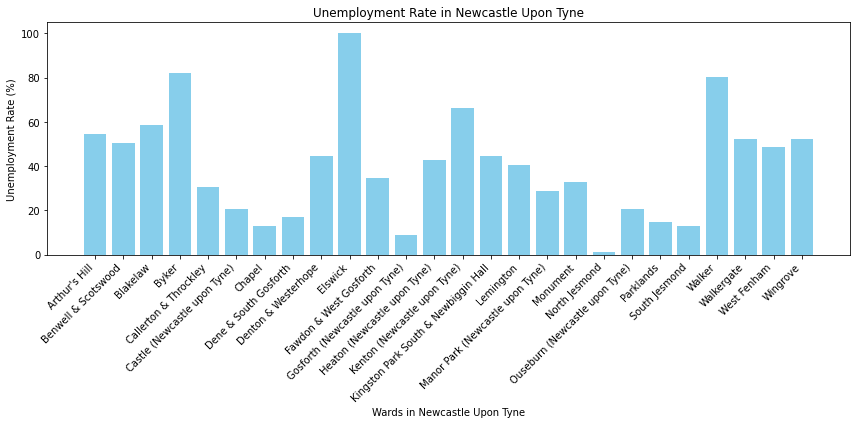

In [257]:
# Plot Unemployment Rate for each city
for city in cities:
    city_data = df[df['City'] == city]
    
    plt.figure(figsize=(12, 6))
    plt.bar(city_data['Name'], city_data['Unemployed (%)'], color='skyblue')
    plt.title(f'Unemployment Rate in {city}')
    plt.xlabel(f'Wards in {city}')
    plt.ylabel('Unemployment Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

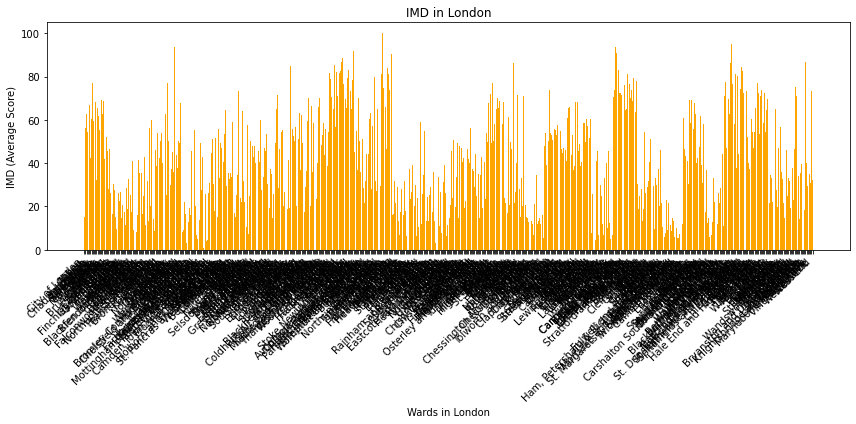

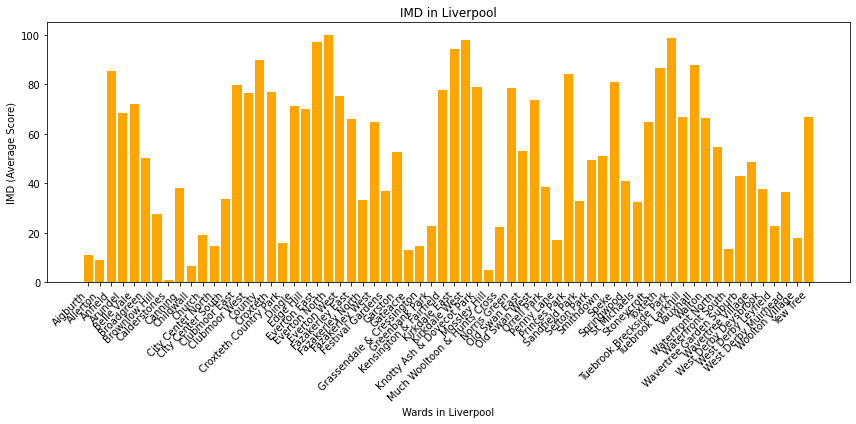

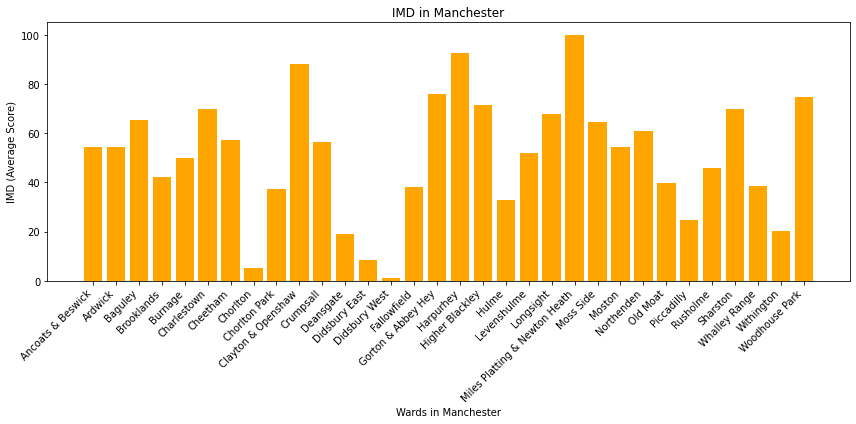

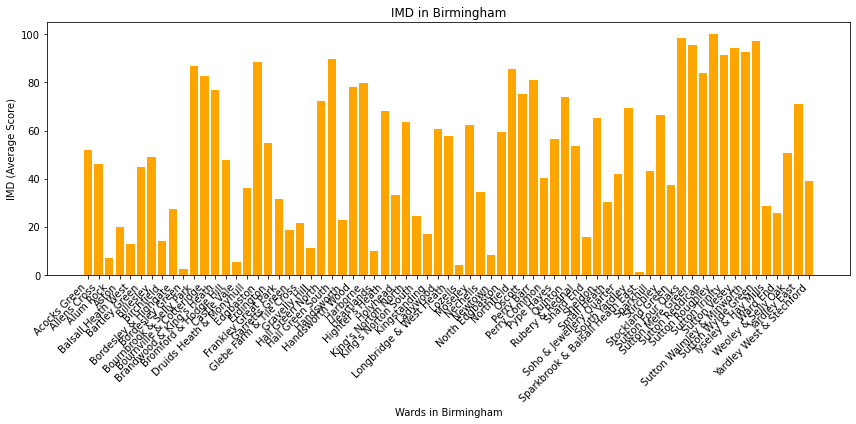

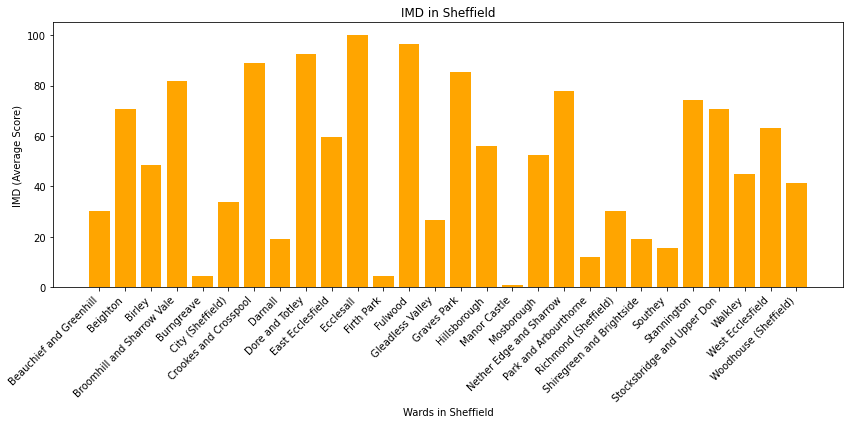

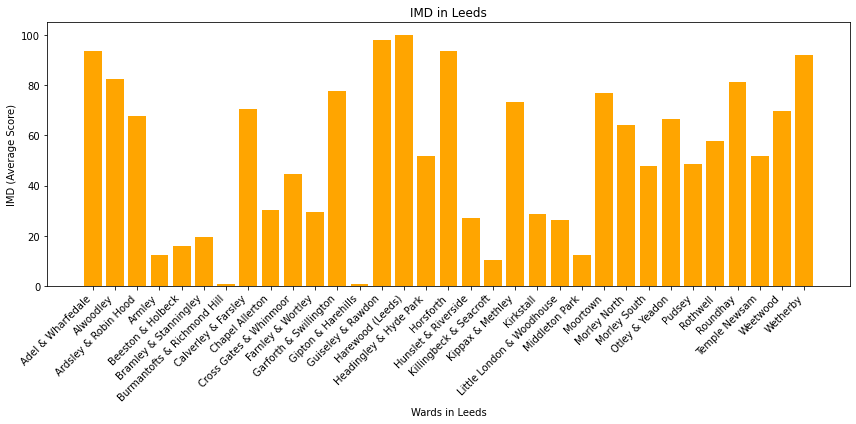

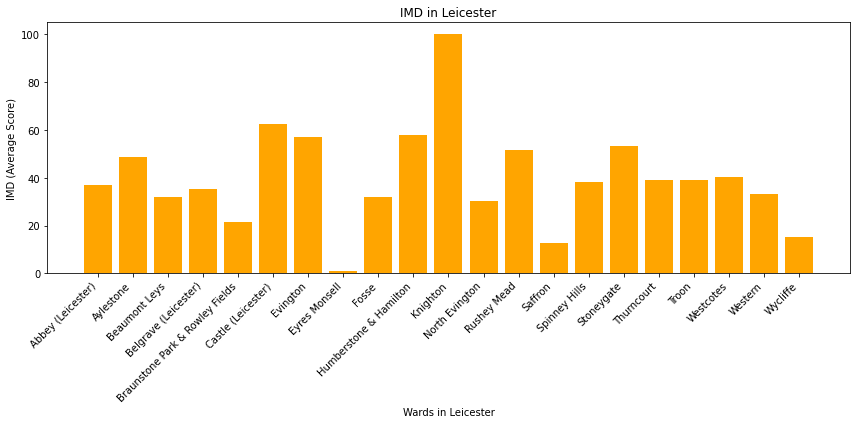

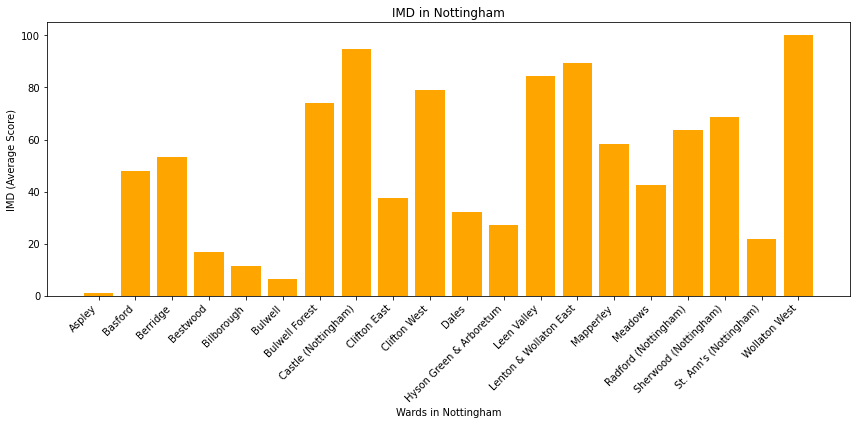

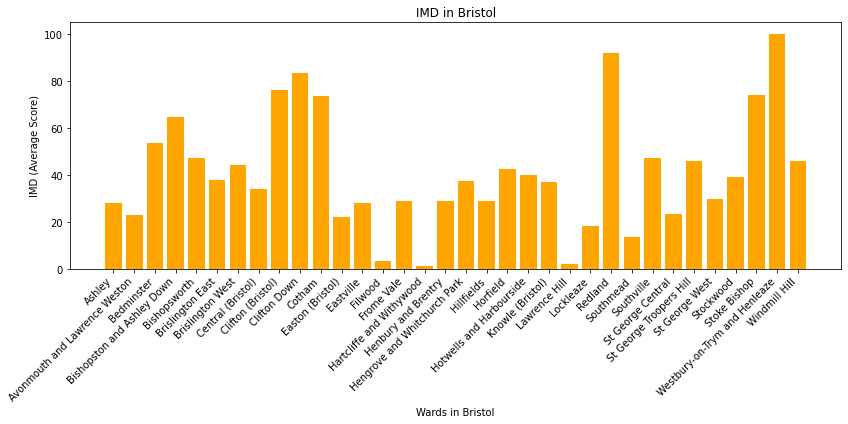

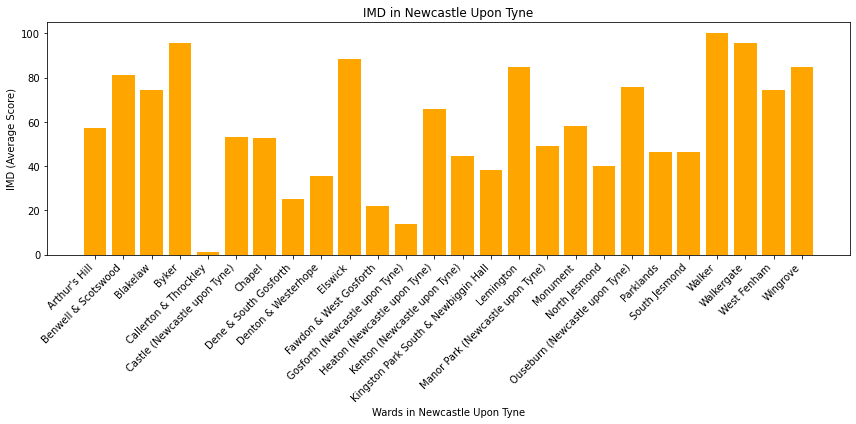

In [258]:
# Plot IMD for each city
for city in cities:
    city_data = df[df['City'] == city]
    
    plt.figure(figsize=(12, 6))
    plt.bar(city_data['Name'], city_data['IMD (Average Score)'], color='orange')
    plt.title(f'IMD in {city}')
    plt.xlabel(f'Wards in {city}')
    plt.ylabel('IMD (Average Score)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

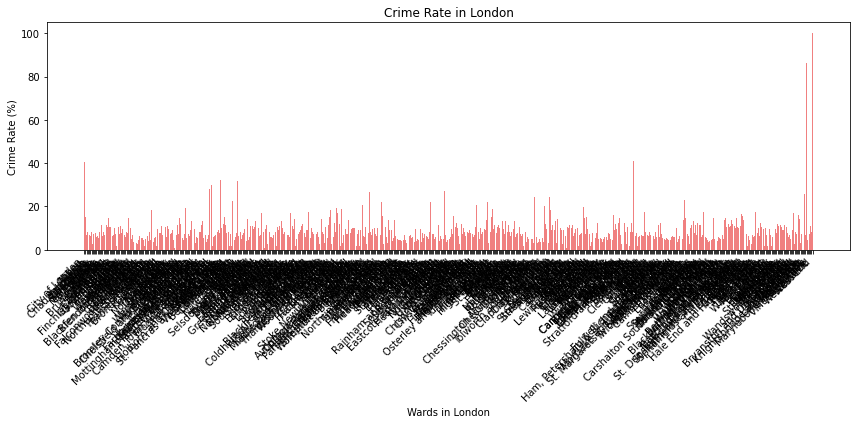

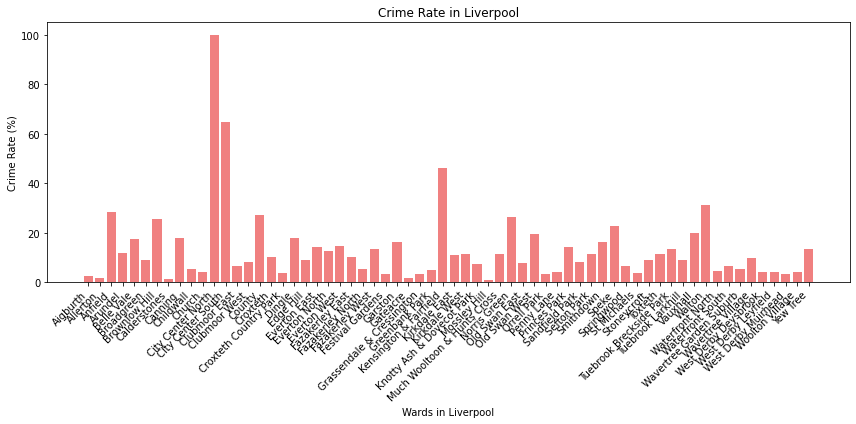

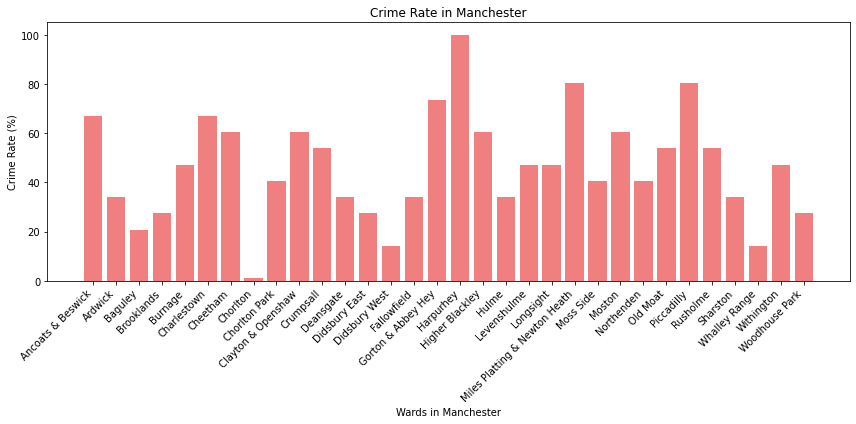

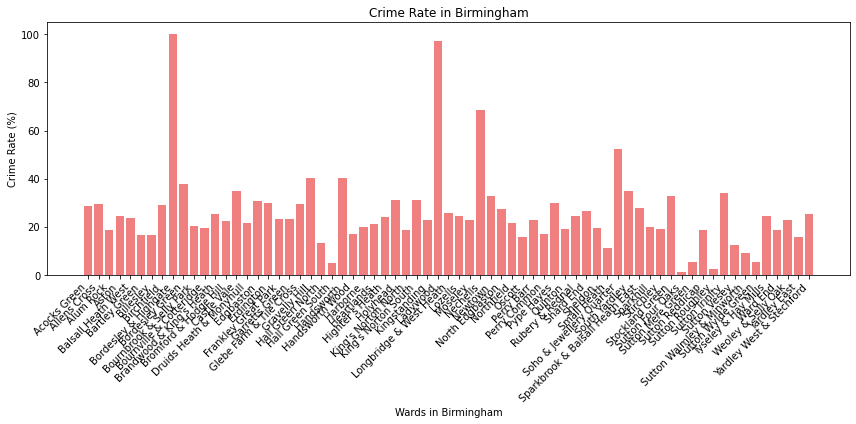

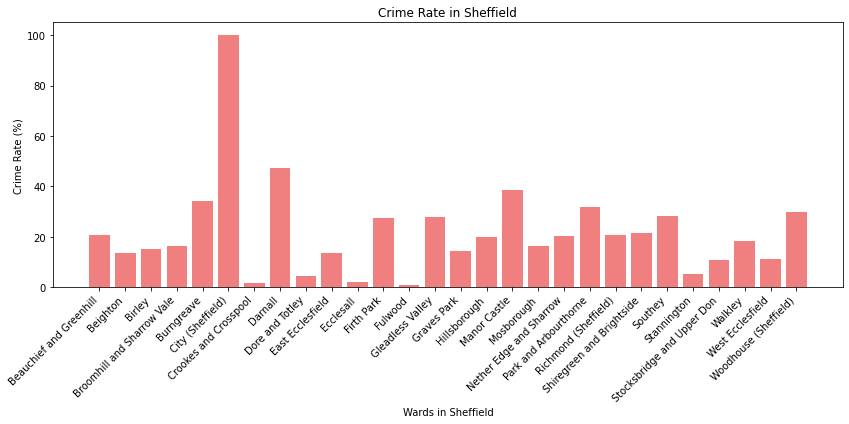

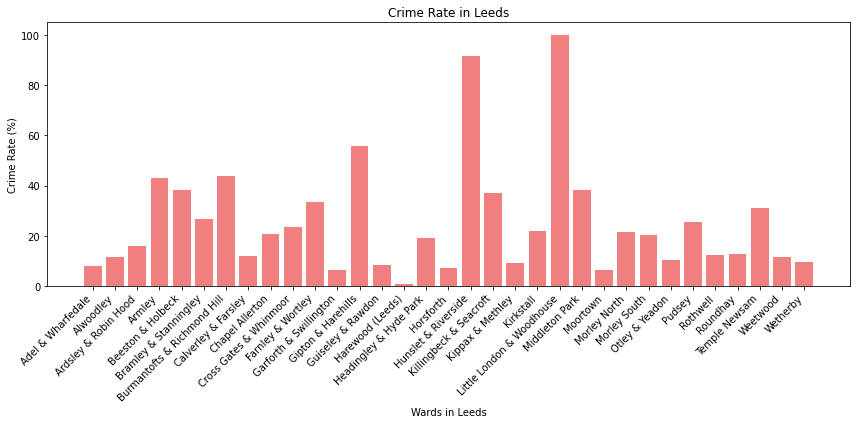

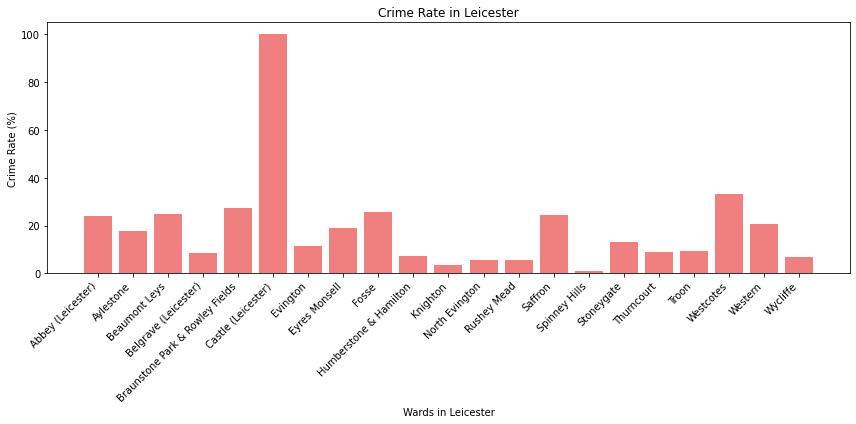

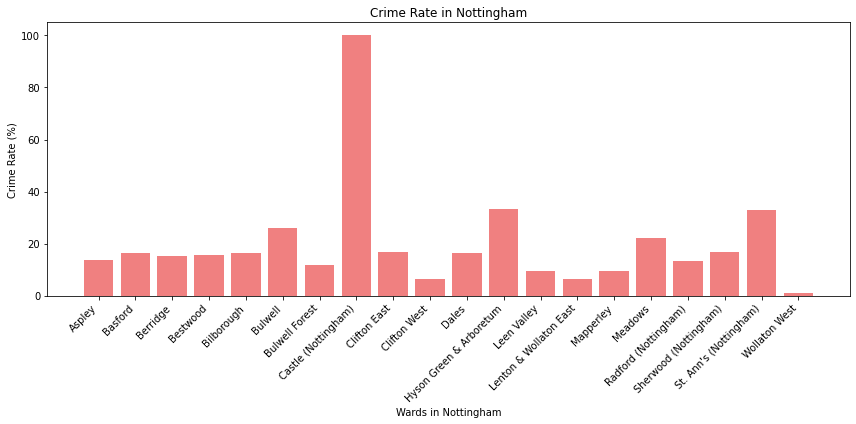

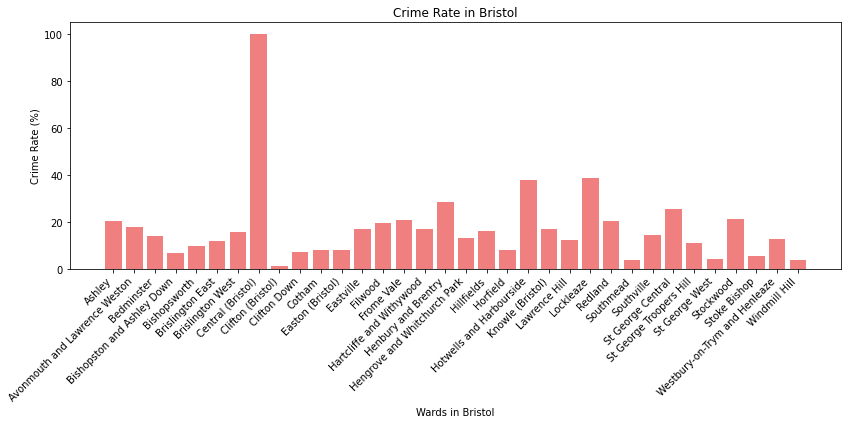

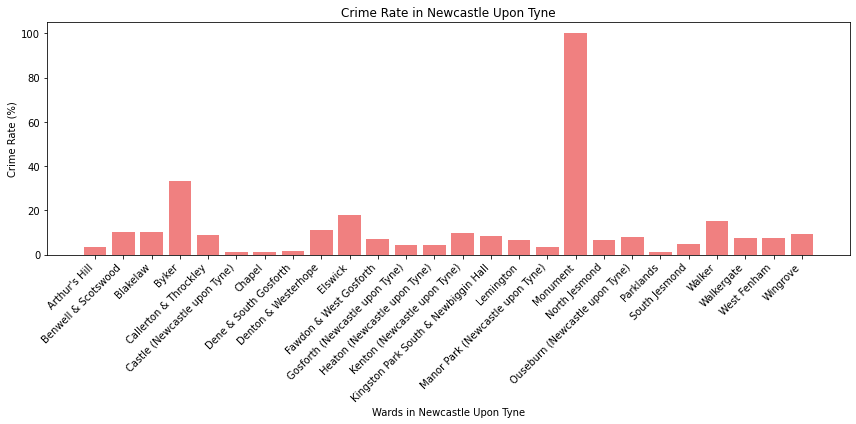

In [259]:
# Plot Crime Rate for each city
for city in cities:
    city_data = df[df['City'] == city]
    
    plt.figure(figsize=(12, 6))
    plt.bar(city_data['Name'], city_data['Crime Rate (%)'], color='lightcoral')
    plt.title(f'Crime Rate in {city}')
    plt.xlabel(f'Wards in {city}')
    plt.ylabel('Crime Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

For this project, we've put together a web application and Users will be looking to have any of the following as a priority or option when defining their ideal community to settle; 
- Low Unemployment Rate (Unemployed (%))
- Low Cost of Living (COL Index)
- Low Average Rent (Rent Index)
- Low Crime Rate (Crime Rate (%))

And since the values are numerical and low values for each of these are typically ideal, we will perform an inversion operation to give the values the right orientation.

In [260]:
# Specifying the columns to invert
invert_cols = ['Unemployed (%)', 'COL Index', 'Rent Index', 'Crime Rate (%)']

# Invert the values for specified columns
df[invert_cols] = 1 / df[invert_cols]

In [261]:
df[invert_cols].head(3)

,Unemployed (%),COL Index,Rent Index,Crime Rate (%)
0,0.105229,0.013369,0.014684,0.024631
1,0.014237,0.013369,0.014684,0.066645
2,0.017771,0.013369,0.014684,0.147164


In [262]:
df.head()

,Name,WardID,White British,Other White,White Irish,White Gypsy or Irish Traveller,Black African,Black Caribbean,Other Black,Pakistani,...,Mixed White and Black Caribbean,Mixed White and Black African,Other Mixed,Other Ethnic Group,Crime Rate (%),Unemployed (%),City,IMD (Average Score),COL Index,Rent Index
0,City of London,1,57.5,18.6,2.4,0.0,0.6,1.3,0.7,0.2,...,0.5,0.5,1.4,1.2,0.024631,0.105229,London,15.284569,0.013369,0.014684
1,Abbey,2,2.0,13.3,0.7,0.3,3.5,17.9,2.5,20.2,...,1.0,1.8,1.5,2.3,0.066645,0.014237,London,56.154309,0.013369,0.014684
2,Alibon,3,61.3,7.8,1.0,0.0,2.0,15.2,1.1,1.1,...,1.2,1.1,0.6,0.7,0.147164,0.017771,London,62.899800,0.013369,0.014684
3,Becontree,4,50.6,7.2,0.9,0.1,3.3,13.0,1.4,5.4,...,1.7,1.2,0.9,1.1,0.121302,0.015154,London,54.170341,0.013369,0.014684
4,Chadwell Heath,5,55.1,5.8,1.2,0.0,4.8,9.4,1.8,3.7,...,1.6,1.5,1.0,1.2,0.147164,0.017965,London,66.669339,0.013369,0.014684


In [263]:
df.to_csv('10merge_final.csv')

This finally preprocessed data '10merge_final.csv' provides the necessary input vector of ward attributes that can be matched against immigrant neighborhood preference criteria. This forms the foundation for training our selected machine learning algorithms to return personalized ward recommendations optimized to each user's priorities on key area features. 

## 4. Model Development

In this phase, several benchmark models representing common recommendation algorithms were identified and developed. Key hyperparameters were tuned using cross-validation techniques to optimize model performance. The models were then fitted on the training dataset and evaluated by making predictions on the test dataset.

##### Benchmark Models
The benchmark models selected for this analysis include:

- K-Nearest Neighbors (KNN)
- Matrix Factorization (NMF)
- Singular Value Decomposition (SVD)
- Collaborative Filtering (CF)
- Random Forest (RF)
- Gradient Boosting Machine (GBM)
- Multi-Layer Perceptron (MLP)
- XGBoost

##### Model Development Process
The process involved specifying initial model parameters, training the models on the training dataset, assessing their performance by making predictions on the test data and attempting to obtain the best performance results by carrying out hyperparameter tuning.

##### User Preferences

To train our model and return recommendations, we need five (3) core details from the user, namely;
- Name - To facilitate personalised referencing and reporting
- Ethnicity - To engage in the case they were to choose High Ethnic Population as one of their priorities
- Priority Ranking - Working with choices requires a weighting system to facilitate ranking and order of preferences on the basis of importance.

Let's now define a sample user input for our model. This is required as it is consistent with the design of our user-friendly web application to be introduced later.

In [106]:
# Defining user preferences (we will get these from user input from the web app)
user_preferences = {
    'first_name': 'Bolu',
    'ethnicity': 'Black African',
    'priority1': 'High Ethnic Population',
    'priority2': 'Low Unemployment Rate',
    'priority3': 'Low Average Cost of Living',
    'priority4': 'Low Crime Rate',
}

# Mapping user's ethnicity to corresponding column
user_ethnicity_column = f"{user_preferences['ethnicity']}"

# Feature Engineering with Weighted Priorities
weights = {
    'priority1': 0.4,
    'priority2': 0.3,
    'priority3': 0.2,
    'priority4': 0.1,
}

In [107]:
# Sample display of our entered user preference values

user_preferences.values()

dict_values(['Bolu', 'Black African', 'High Ethnic Population', 'Low Unemployment Rate', 'Low Average Cost of Living', 'Low Crime Rate'])

Here, we create a dictionary of the preferences to be applied dynamically in our Composite Score calculations later.

In [108]:
# Initializing dictionary to build DataFrame
prefs_dict = {}

# Adding weighted priorities
for key, value in user_preferences.items():
    if "priority" in key:
        prefs_dict[value] = weights[key]


# Conditionally add ethnicity
if "High Ethnic Population" in prefs_dict:
    new_key = user_preferences["ethnicity"]
    prefs_dict[new_key] = prefs_dict.pop("High Ethnic Population")

# Create DataFrame
user_df = pd.DataFrame(prefs_dict, index=[0])

user_df

,Low Unemployment Rate,Low Average Cost of Living,Low Crime Rate,Black African
0,0.3,0.2,0.1,0.4


In [109]:
# Filtering for user selected features from main feature collection
cleaned = pd.read_csv('10merge.csv')
df = cleaned.copy()
column_rename_dict = {
    'Crime Rate (%)': 'Low Crime Rate',
    'Unemployed (%)': 'Low Unemployment Rate',
    'COL Index': 'Low Average Cost of Living',
    'Rent Index': 'Low Average Rent',
    'IMD (Average Score)': 'Low IMD Score'
}
df.rename(columns=column_rename_dict, inplace=True)
df.columns

Index(['Name', 'WardID', 'White British', 'Other White', 'White Irish',
       'White Gypsy or Irish Traveller', 'Black African', 'Black Caribbean',
       'Other Black', 'Pakistani', 'Chinese', 'Indian', 'Bangladeshi',
       'Other Asian', 'Arab', 'Mixed White and Asian',
       'Mixed White and Black Caribbean', 'Mixed White and Black African',
       'Other Mixed', 'Other Ethnic Group', 'Low Crime Rate',
       'Low Unemployment Rate', 'City', 'Low IMD Score',
       'Low Average Cost of Living', 'Low Average Rent'],
      dtype='object')

In [110]:
# Getting columns common to both DataFrames
common_cols = user_df.columns.intersection(df.columns)  

# Subsetting those columns + additional needed ones
selected_cols = list(common_cols) + ['Name', 'City']
selected_df = df[selected_cols].copy()

# Normalizing numeric columns
numeric_cols = selected_df.select_dtypes('number').columns
selected_df[numeric_cols] = (selected_df[numeric_cols] - selected_df[numeric_cols].min()) / (selected_df[numeric_cols].max() - selected_df[numeric_cols].min())

In [112]:
# Calculating Composite Score
scores = []

for index, row in selected_df.iterrows():
    score = 0   
    for col in common_cols:
        weight = user_df.at[0, col]
        value = row[col]
        score += weight * value
        
    scores.append(score)

selected_df['Composite Score'] = scores

# Display
display(selected_df[['Name', 'City', 'Composite Score']])

,Name,City,Composite Score
0,City of London,London,0.271671
1,Abbey,London,0.464100
2,Alibon,London,0.395765
3,Becontree,London,0.442009
4,Chadwell Heath,London,0.426954
...,...,...,...
947,South Jesmond,Newcastle Upon Tyne,0.219801
948,Walker,Newcastle Upon Tyne,0.466645
949,Walkergate,Newcastle Upon Tyne,0.350407
950,West Fenham,Newcastle Upon Tyne,0.340484


Now, that we've obtained 'Composite Score' our target vector, we can go on to train our model. Starting with K-Nearest Neighbors.

In [158]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    selected_df[numeric_cols], 
    selected_df['Composite Score'], 
    test_size=0.2, 
    random_state=42
)

### i. K-Nearest Neighbor (KNN):

In [159]:
# k-NN model
k = 5  # intial k value
knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine')
knn_model.fit(X_train, y_train)

# Making predictions on the user preferences
user_recommendations = knn_model.predict(selected_df[numeric_cols])

# Normalizing predictions
user_recommendations = user_recommendations.reshape(-1, 1)
scaler = MinMaxScaler()
user_recommendations = scaler.fit_transform(user_recommendations)
user_recommendations = user_recommendations.flatten()

# Getting top 5 recommendation indices
sorted_idx = user_recommendations.argsort()[::-1][:5]

cols = ['Name', 'City', 'Composite Score']
top_recommendations = selected_df[cols].iloc[sorted_idx]

# Display the top 5 recommendations
top_recommendations

,Name,City,Composite Score
415,Catford South,London,0.672814
140,Thornton Heath,London,0.647784
871,Wycliffe,Leicester,0.553349
123,Bensham Manor,London,0.610775
75,Stonebridge,London,0.692017


#### Evaluating Initial Model Performance

In [160]:
# Evaluating k-NN
y_pred_knn = knn_model.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)

print("k-NN Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_knn}')
print(f'Mean Absolute Error (MAE): {mae_knn}')
print(f'Root Mean Squared Error (RMSE): {rmse_knn}\n')

k-NN Model Evaluation:
Mean Squared Error (MSE): 0.0069339768844803714
Mean Absolute Error (MAE): 0.04273146206106709
Root Mean Squared Error (RMSE): 0.08327050428861574



#### Tuning for optimum value of k

In [180]:
# Defining a range of k values to test
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

# Initialize the k-NN regressor
knn_model = KNeighborsRegressor(metric='cosine')

# Create GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best k value
best_k = grid_search.best_params_['n_neighbors']

# Train the k-NN model with the best k value
best_knn_model = KNeighborsRegressor(n_neighbors=best_k, metric='cosine')
best_knn_model.fit(X_train, y_train)

# Evaluating the best k-NN model
y_pred_best_knn = best_knn_model.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_best_knn)
mae_knn = mean_absolute_error(y_test, y_pred_best_knn)
rmse_knn = np.sqrt(mse_best_knn)

print(f"Best k: {best_k}")
print(f"Mean Squared Error: {mse_knn}")
print(f"Mean Absolute Error: {mae_knn}")
print(f"Root Mean Squared Error: {rmse_knn}")

Best k: 7
Mean Squared Error: 0.006616150609166946
Mean Absolute Error: 0.04125110464811323
Root Mean Squared Error: 0.08133972343920863


In [181]:
# k-NN model
k = 7  # applying optimal k value
knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine')
knn_model.fit(X_train, y_train)

# Making predictions on the user preferences
user_recommendations = knn_model.predict(selected_df[numeric_cols])

# Normalizing predictions
user_recommendations = user_recommendations.reshape(-1, 1)
scaler = MinMaxScaler()
user_recommendations = scaler.fit_transform(user_recommendations)
user_recommendations = user_recommendations.flatten()

# Getting top 5 recommendation indices
sorted_idx = user_recommendations.argsort()[::-1][:5]

cols = ['Name', 'City', 'Composite Score']
top_recommendations = selected_df[cols].iloc[sorted_idx]

# Display the top 5 recommendations
top_recommendations

,Name,City,Composite Score
415,Catford South,London,0.672814
140,Thornton Heath,London,0.647784
871,Wycliffe,Leicester,0.553349
66,Harlesden,London,0.643889
123,Bensham Manor,London,0.610775


### ii. Matrix Factorization (NMF):

In [154]:
# Choosing the number of latent factors (n_components) on this initial trial run.
n_components = 5

# Initializing the NMF model
nmf_model = NMF(n_components=n_components, init='random', random_state=42)

# Fitting the model to training data
W_train = nmf_model.fit_transform(X_train)
H_train = nmf_model.components_

# Making predictions on the test set
X_test_reconstructed = np.dot(W_train, H_train)
user_recommendations_nmf = X_test_reconstructed[:, 0] 

# Normalizing predictions
user_recommendations_nmf = user_recommendations_nmf.reshape(-1, 1)
scaler_nmf = MinMaxScaler()
user_recommendations_nmf = scaler_nmf.fit_transform(user_recommendations_nmf)
user_recommendations_nmf = user_recommendations_nmf.flatten()

# Getting top 5 recommendation indices for NMF
sorted_idx_nmf = user_recommendations_nmf.argsort()[::-1][:5]

# Getting top 5 rows for NMF
cols_nmf = ['Name', 'City', 'Composite Score']
top_recommendations_nmf = selected_df[cols_nmf].iloc[sorted_idx_nmf]

# top 5 recommendations for NMF
print("Matrix Factorization (NMF) Recommendations:")
top_recommendations_nmf

Matrix Factorization (NMF) Recommendations:


,Name,City,Composite Score
194,Eltham South,London,0.335073
471,Barkingside,London,0.333926
165,Southall Green,London,0.433867
564,Whitechapel,London,0.355312
248,Hornsey,London,0.381835


#### Evaluating Initial Model Performance

In [155]:
# Evaluate Matrix Factorization (NMF)
X_test_reconstructed_nmf = np.dot(W_train, H_train)
user_recommendations_nmf = X_test_reconstructed_nmf[:, 0] 

# Ensure user_recommendations_nmf has the same number of samples as y_test
user_recommendations_nmf = user_recommendations_nmf[:len(y_test)]

# performance evaluation
mse_nmf = mean_squared_error(y_test, user_recommendations_nmf)
mae_nmf = mean_absolute_error(y_test, user_recommendations_nmf)
rmse_nmf = np.sqrt(mse_nmf)

# Display the results
print("Matrix Factorization (NMF) Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_nmf}')
print(f'Mean Absolute Error (MAE): {mae_nmf}')
print(f'Root Mean Squared Error (RMSE): {rmse_nmf}\n')

Matrix Factorization (NMF) Model Evaluation:
Mean Squared Error (MSE): 0.07020593725476644
Mean Absolute Error (MAE): 0.20542333365615395
Root Mean Squared Error (RMSE): 0.26496403011496944



#### Tuning for optimum number of latent factors (n_components)

In [179]:
# Defining a range of n_components values to test
param_grid = {'n_components': [3, 5, 7, 10]}

# Initializing the NMF model
nmf_model = NMF(init='random', random_state=42)

# Creating GridSearchCV
grid_search = GridSearchCV(nmf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train)

# Getting the best n_components value
best_n_components = grid_search.best_params_['n_components']

# Training the NMF model with the best n_components value
best_nmf_model = NMF(n_components=best_n_components, init='random', random_state=42)
best_nmf_model.fit(X_train)

# Getting predictions on the training set (you can use X_test as well)
user_recommendations_nmf_best = best_nmf_model.transform(X_train)[:, 0]

# Evaluate the performance of the best model
mse_best_model = mean_squared_error(y_train, user_recommendations_nmf_best)

mse_nmf = mean_squared_error(y_train, user_recommendations_nmf_best)
mae_nmf = mean_absolute_error(y_train, user_recommendations_nmf_best)
rmse_nmf = mean_squared_error(y_train, user_recommendations_nmf_best, squared=False)

print(f"Optimal n_components: {best_n_components}")
print(f"Mean Squared Error for the best model: {mse_best_model}")
print(f'Mean Squared Error (MSE): {mse_nmf}')
print(f'Mean Absolute Error (MAE): {mae_nmf}')
print(f'Root Mean Squared Error (RMSE): {rmse_nmf}\n')


Optimal n_components: 3
Mean Squared Error for the best model: 0.03437074423664208
Mean Squared Error (MSE): 0.03437074423664208
Mean Absolute Error (MAE): 0.1452657427941488
Root Mean Squared Error (RMSE): 0.18539348488186438



In [175]:
# applying optimal n_components
n_components = 3

# Initializing the NMF model
nmf_model = NMF(n_components=n_components, init='random', random_state=42)

# Fitting the model to training data
W_train = nmf_model.fit_transform(X_train)
H_train = nmf_model.components_

# Making predictions on the test set
X_test_reconstructed = np.dot(W_train, H_train)
user_recommendations_nmf = X_test_reconstructed[:, 0] 

# Normalizing predictions
user_recommendations_nmf = user_recommendations_nmf.reshape(-1, 1)
scaler_nmf = MinMaxScaler()
user_recommendations_nmf = scaler_nmf.fit_transform(user_recommendations_nmf)
user_recommendations_nmf = user_recommendations_nmf.flatten()

# Getting top 5 recommendation indices for NMF
sorted_idx_nmf = user_recommendations_nmf.argsort()[::-1][:5]

# Getting top 5 rows for NMF
cols_nmf = ['Name', 'City', 'Composite Score']
top_recommendations_nmf = selected_df[cols_nmf].iloc[sorted_idx_nmf]

# top 5 recommendations for NMF
print("Matrix Factorization (NMF) Recommendations:")
top_recommendations_nmf

Matrix Factorization (NMF) Recommendations:


,Name,City,Composite Score
290,Hylands,London,0.264492
659,Knotty Ash & Dovecot Park,Liverpool,0.152163
486,Roding,London,0.324800
343,Caledonian,London,0.370781
260,Belmont,London,0.283745


### iii. Singular Value Decomposition (TruncatedSVD):

In [156]:
# Choosing the number of latent factors (n_components)
n_components_svd = 3

# Initializing the SVD model
svd_model = TruncatedSVD(n_components=n_components_svd, random_state=42)

# Fitting the model to training data
X_train_reduced = svd_model.fit_transform(X_train)

# Transforming the test data using the SVD model
X_test_reduced = svd_model.transform(X_test)

# Since 'Composite Score' is the last column
composite_score_column_index = -1

# Evaluate Singular Value Decomposition (SVD)
user_recommendations_svd = np.dot(X_test_reduced, svd_model.components_.T[composite_score_column_index, :])

# Normalizing predictions for SVD
user_recommendations_svd = user_recommendations_svd.reshape(-1, 1)
scaler_svd = MinMaxScaler()
user_recommendations_svd = scaler_svd.fit_transform(user_recommendations_svd)
user_recommendations_svd = user_recommendations_svd.flatten()

# Getting top 5 recommendation indices for SVD
sorted_idx_svd = user_recommendations_svd.argsort()[::-1][:5]

# Getting top 5 rows for SVD
top_recommendations_svd = selected_df[cols].iloc[sorted_idx_svd]

# top 5 recommendations for SVD
print("Singular Value Decomposition (SVD) Recommendations:")
top_recommendations_svd

Singular Value Decomposition (SVD) Recommendations:


,Name,City,Composite Score
128,Fairfield,London,0.371622
11,Mayesbrook,London,0.403315
188,Winchmore Hill,London,0.284907
221,Springfield,London,0.529195
105,Camden Town with Primrose Hill,London,0.313363


#### Evaluating Initial Model Performance

In [157]:
# Evaluating Singular Value Decomposition (SVD)
user_recommendations_svd = np.dot(X_test_reduced, svd_model.components_.T[0, :])  # Assuming 'Composite Score' is the first column

# Calculating performance metrics
mse_svd = mean_squared_error(y_test, user_recommendations_svd)
mae_svd = mean_absolute_error(y_test, user_recommendations_svd)
rmse_svd = np.sqrt(mse_svd)

# Displaying the results
print("Singular Value Decomposition (SVD) Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_svd}')
print(f'Mean Absolute Error (MAE): {mae_svd}')
print(f'Root Mean Squared Error (RMSE): {rmse_svd}\n')

Singular Value Decomposition (SVD) Model Evaluation:
Mean Squared Error (MSE): 0.027566044248487697
Mean Absolute Error (MAE): 0.13015100449120556
Root Mean Squared Error (RMSE): 0.16603025100410979



#### Tuning for optimum number of latent factors (n_components)

In [183]:
# Defining a range of n_components values to test
param_grid = {'n_components': [3, 5, 7, 10]}

# Initializing the SVD model
svd_model = TruncatedSVD(random_state=42)

# Creating GridSearchCV
grid_search = GridSearchCV(svd_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train)

# Getting the best n_components value
best_n_components = grid_search.best_params_['n_components']

# Training the SVD model with the best n_components value on the entire training set
best_svd_model = TruncatedSVD(n_components=best_n_components, random_state=42)
X_train_reduced = best_svd_model.fit_transform(X_train)
X_test_reduced = best_svd_model.transform(X_test)

# Since 'Composite Score' is the last column
composite_score_column_index = -1

# Evaluating Singular Value Decomposition (SVD)
user_recommendations_svd = np.dot(X_test_reduced, best_svd_model.components_.T[composite_score_column_index, :])

# Evaluating the performance of the SVD model using mean squared error (MSE)
mse_svd = mean_squared_error(y_test, user_recommendations_svd)
mae_svd = mean_absolute_error(y_test, user_recommendations_svd)
rmse_svd = mean_squared_error(y_test, user_recommendations_svd, squared=False)

# results
print(f"Optimal n_components (SVD): {best_n_components}")
print(f"Mean Squared Error for the best SVD model: {mse_svd}")
print(f'Mean Absolute Error (MAE) for SVD: {mae_svd}')
print(f'Root Mean Squared Error (RMSE) for SVD: {rmse_svd}\n')

Optimal n_components (SVD): 3
Mean Squared Error for the best SVD model: 0.04407577792107809
Mean Absolute Error (MAE) for SVD: 0.18949479651267861
Root Mean Squared Error (RMSE) for SVD: 0.20994232046225958



Since the optimal number of latent factors is same as was used initially, no need to re-obtain top recommendations.

### iv. Collaborative Filtering (Cosine Similarity):

In [139]:
# Calculating user-user similarity using cosine similarity
user_user_similarity = cosine_similarity(X_test, X_train)

# Initializing array for predictions
user_predictions_cf = np.zeros((X_test.shape[0], X_train.shape[1]))

# Making predictions for missing values (user-based collaborative filtering)
for i in range(X_test.shape[0]):
    for j in range(X_train.shape[1]):
        user_predictions_cf[i, j] = np.sum(user_user_similarity[i, :] * X_train.iloc[:, j]) / np.abs(user_user_similarity[i, :]).sum()

# Normalizing predictions for Collaborative Filtering
user_predictions_cf = user_predictions_cf.reshape(-1, 1)
scaler_cf = MinMaxScaler()
user_predictions_cf = scaler_cf.fit_transform(user_predictions_cf)
user_predictions_cf = user_predictions_cf.flatten()

# top 5 recommendation indices
sorted_idx_cf = user_predictions_cf.argsort()[::-1][:5]
top_recommendations_cf = selected_df[cols].iloc[sorted_idx_cf]

# top 5 recommendations
print("Collaborative Filtering Recommendations:")
top_recommendations_cf

Collaborative Filtering Recommendations:


,Name,City,Composite Score
581,Markhouse,London,0.411920
553,Bromley-by-Bow,London,0.510400
201,Plumstead,London,0.466374
729,Bordesley & Highgate,Birmingham,0.539463
17,Whalebone,London,0.440545


#### Evaluating Initial Model Performance

In [140]:
# Evaluate Collaborative Filtering
user_item_similarity_test = cosine_similarity(X_test)
user_predictions_cf = user_item_similarity_test.dot(X_test) / np.abs(user_item_similarity_test).sum(axis=1, keepdims=True)

mse_cf = mean_squared_error(y_test, user_predictions_cf[:, 0]) 
mae_cf = mean_absolute_error(y_test, user_predictions_cf[:, 0])
rmse_cf = np.sqrt(mse_cf)

print("Collaborative Filtering Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_cf}')
print(f'Mean Absolute Error (MAE): {mae_cf}')
print(f'Root Mean Squared Error (RMSE): {rmse_cf}')

Collaborative Filtering Model Evaluation:
Mean Squared Error (MSE): 0.020517986998403247
Mean Absolute Error (MAE): 0.11109228609366634
Root Mean Squared Error (RMSE): 0.14324101018354782


#### Tuning for optimum number of Neighborhoods with CF

In [188]:
# lets get a function that can help investigate the ideal neighborhood size

def collaborative_filtering(X_test, X_train, y_test, neighborhood_size):
    # Ensuring input shapes match
    assert X_test.shape[0] == len(y_test), "Inconsistent number of samples between X_test and y_test"
    assert X_test.shape[1] == X_train.shape[1], "Inconsistent number of features between X_test and X_train"

    # Calculating user-user similarity using cosine similarity
    user_user_similarity = cosine_similarity(X_test, X_train)

    # Initializing array for predictions
    user_predictions_cf = np.zeros((X_test.shape[0],))

    # Making predictions for missing values (user-based collaborative filtering)
    for i in range(X_test.shape[0]):
        # Sort users based on similarity and select the top 'neighborhood_size' users
        similar_users = np.argsort(user_user_similarity[i, :])[-neighborhood_size:][::-1]

        # Calculate predictions based on the selected similar users
        user_predictions_cf[i] = np.sum(user_user_similarity[i, similar_users] * y_train.iloc[similar_users]) / np.abs(user_user_similarity[i, similar_users]).sum()

    # Evaluate Collaborative Filtering model
    mse_cf = mean_squared_error(y_test, user_predictions_cf)
    mae_cf = mean_absolute_error(y_test, user_predictions_cf)
    rmse_cf = np.sqrt(mse_cf)

    return mse_cf, mae_cf, rmse_cf

In [189]:
# Testing different neighborhood sizes to find the best one
best_neighborhood_size = None
best_mse = float('inf')

neighborhood_sizes_to_try = [5, 10, 15, 20, 25]

for neighborhood_size in neighborhood_sizes_to_try:
    mse_cf, _, _ = collaborative_filtering(X_test, X_train, y_test, neighborhood_size)
    
    if mse_cf < best_mse:
        best_mse = mse_cf
        best_neighborhood_size = neighborhood_size

# results for the best configuration
print(f"Best Neighborhood Size: {best_neighborhood_size}")

# Evaluating the best configuration
mse_cf, mae_cf, rmse_cf = collaborative_filtering(X_test, X_train, y_test, best_neighborhood_size)

print("Collaborative Filtering Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_cf}')
print(f'Mean Absolute Error (MAE): {mae_cf}')
print(f'Root Mean Squared Error (RMSE): {rmse_cf}')

Best Neighborhood Size: 15
Collaborative Filtering Model Evaluation:
Mean Squared Error (MSE): 0.00661823142016772
Mean Absolute Error (MAE): 0.04157924325923314
Root Mean Squared Error (RMSE): 0.08135251329963765


In [190]:
# Calculating user-user similarity using cosine similarity
user_user_similarity = cosine_similarity(X_test, X_train)

# Initializing array for predictions
user_predictions_cf = np.zeros((X_test.shape[0], X_train.shape[1]))

# Making predictions for missing values (user-based collaborative filtering)
for i in range(X_test.shape[0]):
    # Sort users based on similarity and select the top 'neighborhood_size' users
    similar_users = np.argsort(user_user_similarity[i, :])[-15:][::-1]

    for j in range(X_train.shape[1]):
        # Calculate predictions based on the selected similar users
        user_predictions_cf[i, j] = np.sum(user_user_similarity[i, similar_users] * X_train.iloc[similar_users, j]) / np.abs(user_user_similarity[i, similar_users]).sum()

# Normalizing predictions for Collaborative Filtering
user_predictions_cf = user_predictions_cf.reshape(-1, 1)
scaler_cf = MinMaxScaler()
user_predictions_cf = scaler_cf.fit_transform(user_predictions_cf)
user_predictions_cf = user_predictions_cf.flatten()

# top 5 recommendation indices
sorted_idx_cf = user_predictions_cf.argsort()[::-1][:5]
top_recommendations_cf = selected_df[cols].iloc[sorted_idx_cf]

# top 5 recommendations
print("Collaborative Filtering Recommendations:")
top_recommendations_cf

Collaborative Filtering Recommendations:


,Name,City,Composite Score
529,Village,London,0.266549
545,Wallington South,London,0.293245
477,Cranbrook,London,0.381671
385,Old Malden,London,0.242301
637,City Center South,Liverpool,0.087505


### v. Random Forest Regression (RF)

In [141]:
# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Making predictions for Random Forest
rf_user_recommendations = rf_model.predict(selected_df[numeric_cols])

# Normalizing predictions for Random Forest
rf_user_recommendations = rf_user_recommendations.reshape(-1, 1)
scaler_rf = MinMaxScaler()
rf_user_recommendations = scaler_rf.fit_transform(rf_user_recommendations)
rf_user_recommendations = rf_user_recommendations.flatten()

# Getting top 5 recommendation indices for Random Forest
sorted_idx_rf = rf_user_recommendations.argsort()[::-1][:5]

# top 5 rows for Random Forest
top_recommendations_rf = selected_df[cols].iloc[sorted_idx_rf]

# Displaying the top 5 recommendations for Random Forest
print("Random Forest Recommendations:")
top_recommendations_rf

Random Forest Recommendations:


,Name,City,Composite Score
395,Coldharbour,London,0.721751
914,Lawrence Hill,Bristol,0.678316
75,Stonebridge,London,0.692017
711,Moss Side,Manchester,0.598886
251,Northumberland Park,London,0.672789


#### Evaluating Initial Model Performance

In [142]:
# Evaluating the Random Forest model
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'Mean Absolute Error (MAE): {mae_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}\n')

Random Forest Model Evaluation:
Mean Squared Error (MSE): 0.0002708471672313886
Mean Absolute Error (MAE): 0.00876486484854758
Root Mean Squared Error (RMSE): 0.016457435013737365



#### Tuning for optimum performance via multi-parameter adjustment

In [191]:
# Defining the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initializing the model
rf_model = RandomForestRegressor(random_state=42)

# Creating GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Training a Random Forest model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred_rf_best = best_rf_model.predict(X_test)

# Calculating evaluation metrics
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
rmse_rf_best = np.sqrt(mse_rf_best)

# Print the results
print("Random Forest Model Evaluation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error (MSE): {mse_rf_best}')
print(f'Mean Absolute Error (MAE): {mae_rf_best}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf_best}\n')

Random Forest Model Evaluation:
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error (MSE): 0.0002714628836507864
Mean Absolute Error (MAE): 0.008927615510966852
Root Mean Squared Error (RMSE): 0.016476130724499195



In [193]:
mse_rf = mse_rf_best
mae_rf = mae_rf_best
rmse_rf = rmse_rf_best

Applying the best parameters

In [194]:
# Best hyperparameters
best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# Creating the regressor with the specified hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Training the model
best_rf_model.fit(X_train, y_train)

# Making predictions for Random Forest using the best model
rf_user_recommendations = best_rf_model.predict(selected_df[numeric_cols])

# Normalizing predictions for Random Forest
rf_user_recommendations = rf_user_recommendations.reshape(-1, 1)
scaler_rf = MinMaxScaler()
rf_user_recommendations = scaler_rf.fit_transform(rf_user_recommendations)
rf_user_recommendations = rf_user_recommendations.flatten()

# Getting top 5 recommendation indices for Random Forest
sorted_idx_rf = rf_user_recommendations.argsort()[::-1][:5]

# Columns to display
cols = ['Name', 'City', 'Composite Score']

# Top 5 rows for Random Forest
top_recommendations_rf = selected_df[cols].iloc[sorted_idx_rf]

# Displaying the top 5 recommendations for Random Forest
print("Random Forest Recommendations:")
print(f'Used Hyperparameters: {best_params}')
top_recommendations_rf

Random Forest Recommendations:
Used Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


,Name,City,Composite Score
395,Coldharbour,London,0.721751
914,Lawrence Hill,Bristol,0.678316
75,Stonebridge,London,0.692017
415,Catford South,London,0.672814
711,Moss Side,Manchester,0.598886


### vi. Gradient Boosted Regression Trees (GBRT)

In [143]:
# GBRT
gbrt_model = GradientBoostingRegressor()
gbrt_model.fit(X_train, y_train)

# Making predictions for GBRT
gbrt_user_recommendations = gbrt_model.predict(selected_df[numeric_cols])

# Normalizing predictions for GBRT
gbrt_user_recommendations = gbrt_user_recommendations.reshape(-1, 1)
scaler_gbrt = MinMaxScaler()
gbrt_user_recommendations = scaler_gbrt.fit_transform(gbrt_user_recommendations)
gbrt_user_recommendations = gbrt_user_recommendations.flatten()

# Getting top 5 recommendation indices for GBRT
sorted_idx_gbrt = gbrt_user_recommendations.argsort()[::-1][:5]

#top 5 rows for GBRT
top_recommendations_gbrt = selected_df[cols].iloc[sorted_idx_gbrt]

# Display
print("GBRT Recommendations:")
top_recommendations_gbrt

GBRT Recommendations:


,Name,City,Composite Score
395,Coldharbour,London,0.721751
75,Stonebridge,London,0.692017
914,Lawrence Hill,Bristol,0.678316
415,Catford South,London,0.672814
251,Northumberland Park,London,0.672789


#### Evaluating Initial Model Performance

In [144]:
# Evaluating GBRT
y_pred_gbrt = gbrt_model.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gbrt)
mae_gb = mean_absolute_error(y_test, y_pred_gbrt)
rmse_gb = np.sqrt(mse_gb)

print("Gradient Boosted Regression Trees Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_gb}')
print(f'Mean Absolute Error (MAE): {mae_gb}')
print(f'Root Mean Squared Error (RMSE): {rmse_gb}\n')

Gradient Boosted Regression Trees Model Evaluation:
Mean Squared Error (MSE): 0.00022645875260957134
Mean Absolute Error (MAE): 0.008787843888485702
Root Mean Squared Error (RMSE): 0.015048546528139231



#### Tuning for optimum performance via multi-parameter adjustment

In [195]:
# Defining the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Creating a Gradient Boosting Regressor
gbrt_model = GradientBoostingRegressor(random_state=42)

# Creating GridSearchCV
grid_search = GridSearchCV(gbrt_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Training a Gradient Boosting model with the best hyperparameters
best_gbrt_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gbrt_model.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred_gbrt_best = best_gbrt_model.predict(X_test)

# Calculating evaluation metrics
mse_gbrt_best = mean_squared_error(y_test, y_pred_gbrt_best)
mae_gbrt_best = mean_absolute_error(y_test, y_pred_gbrt_best)
rmse_gbrt_best = np.sqrt(mse_gbrt_best)

# results
print("Gradient Boosted Regression Trees Model Evaluation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error (MSE): {mse_gbrt_best}')
print(f'Mean Absolute Error (MAE): {mae_gbrt_best}')
print(f'Root Mean Squared Error (RMSE): {rmse_gbrt_best}\n')

Gradient Boosted Regression Trees Model Evaluation:
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Mean Squared Error (MSE): 0.00013627390375336735
Mean Absolute Error (MAE): 0.00721963553160519
Root Mean Squared Error (RMSE): 0.011673641409319003



In [200]:
mse_gb = mse_gbrt_best
mae_gb = mae_gbrt_best
rmse_gb = rmse_gbrt_best

In [197]:
# Best parameters
best_params = {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}

# Train a Gradient Boosting model with the best hyperparameters
best_gbrt_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gbrt_model.fit(X_train, y_train)

# Making predictions for GBRT on the entire dataset
gbrt_user_recommendations = best_gbrt_model.predict(selected_df[numeric_cols])

# Normalizing predictions for GBRT
gbrt_user_recommendations = gbrt_user_recommendations.reshape(-1, 1)
scaler_gbrt = MinMaxScaler()
gbrt_user_recommendations = scaler_gbrt.fit_transform(gbrt_user_recommendations)
gbrt_user_recommendations = gbrt_user_recommendations.flatten()

# Getting top 5 recommendation indices for GBRT
sorted_idx_gbrt = gbrt_user_recommendations.argsort()[::-1][:5]

# Top 5 rows for GBRT
top_recommendations_gbrt = selected_df[cols].iloc[sorted_idx_gbrt]

# Display
print("GBRT Recommendations:")
top_recommendations_gbrt

GBRT Recommendations:


,Name,City,Composite Score
395,Coldharbour,London,0.721751
75,Stonebridge,London,0.692017
914,Lawrence Hill,Bristol,0.678316
415,Catford South,London,0.672814
251,Northumberland Park,London,0.672789


### vii. Multi-Layer Perceptron (MLP)

In [198]:
# MLP
mlp_model = MLPRegressor()
mlp_model.fit(X_train, y_train)

# Making predictions for MLP
mlp_user_recommendations = mlp_model.predict(selected_df[numeric_cols])

# Normaliziing predictions for MLP
mlp_user_recommendations = mlp_user_recommendations.reshape(-1, 1)
scaler_mlp = MinMaxScaler()
mlp_user_recommendations = scaler_mlp.fit_transform(mlp_user_recommendations)
mlp_user_recommendations = mlp_user_recommendations.flatten()

# Getting top 5 recommendation indices for MLP
sorted_idx_mlp = mlp_user_recommendations.argsort()[::-1][:5]

# top 5 rows for MLP
top_recommendations_mlp = selected_df[cols].iloc[sorted_idx_mlp]

# Display
print("MLP Recommendations:")
top_recommendations_mlp

MLP Recommendations:


,Name,City,Composite Score
395,Coldharbour,London,0.721751
415,Catford South,London,0.672814
75,Stonebridge,London,0.692017
914,Lawrence Hill,Bristol,0.678316
140,Thornton Heath,London,0.647784


#### Evaluating Initial Model Performance

In [148]:
# Evaluating MLP
y_pred_mlp = mlp_model.predict(X_test)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)

print("Multi-Layer Perceptron Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_mlp}')
print(f'Mean Absolute Error (MAE): {mae_mlp}')
print(f'Root Mean Squared Error (RMSE): {rmse_mlp}\n')

Multi-Layer Perceptron Model Evaluation:
Mean Squared Error (MSE): 5.7159588305711485e-05
Mean Absolute Error (MAE): 0.004906524673979821
Root Mean Squared Error (RMSE): 0.007560396041591438



#### Tuning for optimum performance via multi-parameter adjustment

In [199]:
# Defining the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Initializing the model
mlp_model = MLPRegressor(random_state=42)

# Creating GridSearchCV
grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Training the MLP model with the best hyperparameters
best_mlp_model = MLPRegressor(**best_params, random_state=42)
best_mlp_model.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred_mlp_best = best_mlp_model.predict(X_test)

# Calculating evaluation metrics
mse_mlp_best = mean_squared_error(y_test, y_pred_mlp_best)
mae_mlp_best = mean_absolute_error(y_test, y_pred_mlp_best)
rmse_mlp_best = np.sqrt(mse_mlp_best)

# Printing the results
print("Multi-Layer Perceptron Model Evaluation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error (MSE): {mse_mlp_best}')
print(f'Mean Absolute Error (MAE): {mae_mlp_best}')
print(f'Root Mean Squared Error (RMSE): {rmse_mlp_best}\n')


Multi-Layer Perceptron Model Evaluation:
Best Hyperparameters: {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}
Mean Squared Error (MSE): 2.3057950282079815e-06
Mean Absolute Error (MAE): 0.0011178005290617822
Root Mean Squared Error (RMSE): 0.001518484451091937



In [202]:
mse_mlp = mse_mlp_best
mae_mlp = mae_mlp_best
rmse_mlp = rmse_mlp_best

In [201]:
best_params = {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}

# Train an MLP model with the best hyperparameters
best_mlp_model = MLPRegressor(**best_params, random_state=42)
best_mlp_model.fit(X_train, y_train)

# Making predictions for MLP on the entire dataset
mlp_user_recommendations = best_mlp_model.predict(selected_df[numeric_cols])

# Normalizing predictions for MLP
mlp_user_recommendations = mlp_user_recommendations.reshape(-1, 1)
scaler_mlp = MinMaxScaler()
mlp_user_recommendations = scaler_mlp.fit_transform(mlp_user_recommendations)
mlp_user_recommendations = mlp_user_recommendations.flatten()

# Getting top 5 recommendation indices for MLP
sorted_idx_mlp = mlp_user_recommendations.argsort()[::-1][:5]

# Top 5 rows for MLP
top_recommendations_mlp = selected_df[cols].iloc[sorted_idx_mlp]

# Display
print("MLP Recommendations:")
top_recommendations_mlp

MLP Recommendations:


,Name,City,Composite Score
395,Coldharbour,London,0.721751
75,Stonebridge,London,0.692017
914,Lawrence Hill,Bristol,0.678316
415,Catford South,London,0.672814
251,Northumberland Park,London,0.672789


### viii. XGBoost

In [146]:
# XGBoost
xgboost_model = xgb.XGBRegressor()
xgboost_model.fit(X_train, y_train)

# Making predictions for XGBoost
xgboost_user_recommendations = xgboost_model.predict(selected_df[numeric_cols])

# Normalizing predictions for XGBoost
xgboost_user_recommendations = xgboost_user_recommendations.reshape(-1, 1)
scaler_xgboost = MinMaxScaler()
xgboost_user_recommendations = scaler_xgboost.fit_transform(xgboost_user_recommendations)
xgboost_user_recommendations = xgboost_user_recommendations.flatten()

# Getting top 5 recommendation indices for XGBoost
sorted_idx_xgboost = xgboost_user_recommendations.argsort()[::-1][:5]

# top 5 rows for XGBoost
top_recommendations_xgboost = selected_df[cols].iloc[sorted_idx_xgboost]

# Displaying the top 5 recommendations for XGBoost
print("XGBoost Recommendations:")
top_recommendations_xgboost

XGBoost Recommendations:


,Name,City,Composite Score
395,Coldharbour,London,0.721751
75,Stonebridge,London,0.692017
914,Lawrence Hill,Bristol,0.678316
415,Catford South,London,0.672814
251,Northumberland Park,London,0.672789


#### Evaluating Initial Model Performance

In [147]:
# Evaluating XGBoost
y_pred_xgboost = xgboost_model.predict(X_test)

mse_xgboost = mean_squared_error(y_test, y_pred_xgboost)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
rmse_xgboost = np.sqrt(mse_xgboost)

print("XGBoost Model Evaluation:")
print(f'Mean Squared Error (MSE): {mse_xgboost}')
print(f'Mean Absolute Error (MAE): {mae_xgboost}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgboost}\n')

XGBoost Model Evaluation:
Mean Squared Error (MSE): 0.0002674054754165066
Mean Absolute Error (MAE): 0.008012455814332803
Root Mean Squared Error (RMSE): 0.016352537277636966



#### Tuning for optimum performance via multi-parameter adjustment

In [203]:
# Defining the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Creating an XGBoost Regressor model
xgboost_model = xgb.XGBRegressor(random_state=42)

# Creating GridSearchCV
grid_search = GridSearchCV(xgboost_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_

# Training the XGBoost model with the best hyperparameters
best_xgboost_model = xgb.XGBRegressor(**best_params, random_state=42)
best_xgboost_model.fit(X_train, y_train)

# Evaluating the model on the test set
y_pred_xgboost_best = best_xgboost_model.predict(X_test)

# Calculating evaluation metrics
mse_xgboost_best = mean_squared_error(y_test, y_pred_xgboost_best)
mae_xgboost_best = mean_absolute_error(y_test, y_pred_xgboost_best)
rmse_xgboost_best = np.sqrt(mse_xgboost_best)

# Printing the results
print("XGBoost Model Evaluation:")
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error (MSE): {mse_xgboost_best}')
print(f'Mean Absolute Error (MAE): {mae_xgboost_best}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgboost_best}\n')

XGBoost Model Evaluation:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Mean Squared Error (MSE): 0.00015277318325376994
Mean Absolute Error (MAE): 0.006977335876335009
Root Mean Squared Error (RMSE): 0.012360144952781498



In [205]:
mse_xgboost = mse_xgboost_best
mae_xgboost = mae_xgboost_best
rmse_xgboost = rmse_xgboost_best

In [204]:
best_params = {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}

# Train an XGBoost model with the best hyperparameters
best_xgboost_model = xgb.XGBRegressor(**best_params, random_state=42)
best_xgboost_model.fit(X_train, y_train)

# Making predictions for XGBoost on the entire dataset
xgboost_user_recommendations = best_xgboost_model.predict(selected_df[numeric_cols])

# Normalizing predictions for XGBoost
xgboost_user_recommendations = xgboost_user_recommendations.reshape(-1, 1)
scaler_xgboost = MinMaxScaler()
xgboost_user_recommendations = scaler_xgboost.fit_transform(xgboost_user_recommendations)
xgboost_user_recommendations = xgboost_user_recommendations.flatten()

# Getting top 5 recommendation indices for XGBoost
sorted_idx_xgboost = xgboost_user_recommendations.argsort()[::-1][:5]

# Top 5 rows for XGBoost
top_recommendations_xgboost = selected_df[cols].iloc[sorted_idx_xgboost]

# Displaying the top 5 recommendations for XGBoost
print("XGBoost Recommendations:")
top_recommendations_xgboost

XGBoost Recommendations:


,Name,City,Composite Score
395,Coldharbour,London,0.721751
75,Stonebridge,London,0.692017
914,Lawrence Hill,Bristol,0.678316
415,Catford South,London,0.672814
251,Northumberland Park,London,0.672789


### Result Review

In [206]:
# Creating a dictionary to store the results
results_dict = {
    'Model': ['k-NN', 'Matrix Factorization (NMF)', 'Singular Value Decomposition (SVD)', 'Collaborative Filtering', 'Random Forest', 'Gradient Boosted Trees', 'Multi-Layer Perceptron', 'XGBoost'],
    'MSE': [mse_knn, mse_nmf, mse_svd, mse_cf, mse_rf, mse_gb, mse_mlp, mse_xgboost],
    'MAE': [mae_knn, mae_nmf, mae_svd, mae_cf, mae_rf, mae_gb, mae_mlp, mae_xgboost],
    'RMSE': [rmse_knn, rmse_nmf, rmse_svd, rmse_cf, rmse_rf, rmse_gb, rmse_mlp, rmse_xgboost]
}

# DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

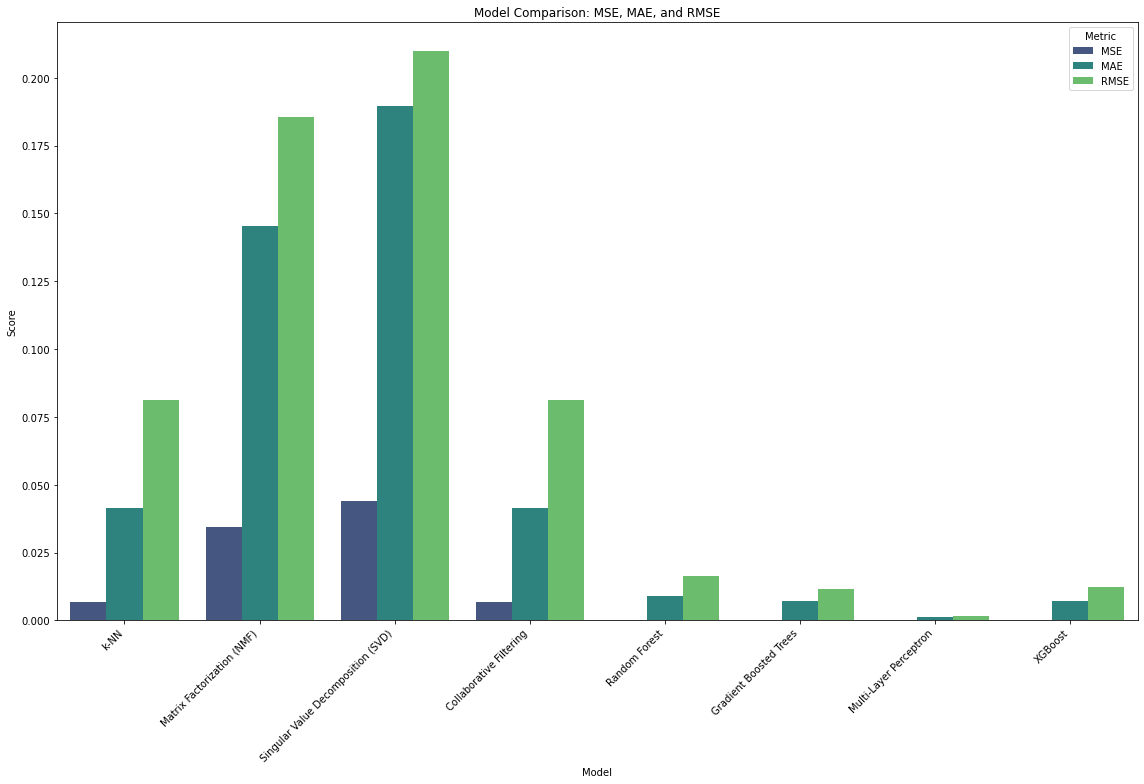

In [304]:
plt.figure(figsize=(16, 11))

melted_df = pd.melt(results_df, id_vars=['Model'], var_name='Metric', value_name='Score')

# Grouped bar plot
sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df, palette='viridis')
plt.title('Model Comparison: MSE, MAE, and RMSE')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right') 
plt.legend(title='Metric')

plt.tight_layout()
plt.show()

In [207]:
results_df

,Model,MSE,MAE,RMSE
0,k-NN,0.006616,0.041251,0.081340
1,Matrix Factorization (NMF),0.034371,0.145266,0.185393
2,Singular Value Decomposition (SVD),0.044076,0.189495,0.209942
3,Collaborative Filtering,0.006618,0.041579,0.081353
4,Random Forest,0.000271,0.008928,0.016476
5,Gradient Boosted Trees,0.000136,0.007220,0.011674
6,Multi-Layer Perceptron,0.000002,0.001118,0.001518
7,XGBoost,0.000153,0.006977,0.012360


It's evident that the Multi-Layer Perceptron (MLP) outperformed the others. I'd like to further investigate this so as to rule out possible cases of overfitting. 

Plotting Training and Testing Errors

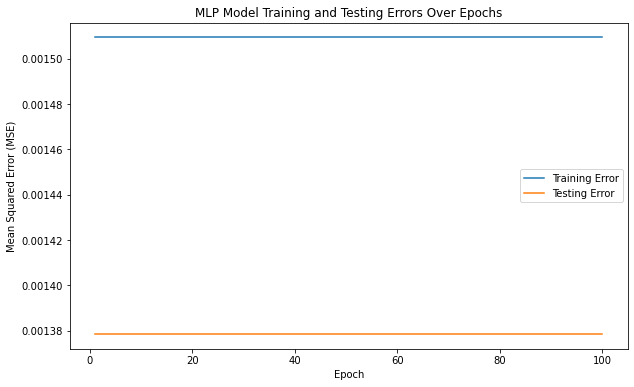

In [208]:
# MLP
mlp_model = MLPRegressor(random_state=42)
train_errors = []
test_errors = []

# Train the model and monitor errors during training
for i in range(1, 101):  # Assume 100 epochs for illustration
    mlp_model.fit(X_train, y_train)
    
    # Training error
    train_predictions = mlp_model.predict(X_train)
    mse_train = mean_squared_error(y_train, train_predictions)
    train_errors.append(mse_train)

    # Testing error
    mlp_user_recommendations = mlp_model.predict(X_test)
    mse_test = mean_squared_error(y_test, mlp_user_recommendations)
    test_errors.append(mse_test)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_errors, label='Training Error')
plt.plot(range(1, 101), test_errors, label='Testing Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MLP Model Training and Testing Errors Over Epochs')
plt.legend()
plt.show()

Based on the training and testing errors provided for the Multi-Layer Perceptron model across 100 training epochs, we can make a few key observations:

The training error remains constant at 0.001509 across all epochs. This indicates that the model has likely converged very early in training and is no longer updating weights to improve fitting on the training data.
Similarly, the testing error is unchanged at 0.001379 over the epochs. This highly consistent performance on held-out data from epoch to epoch reinforces that learning has plateaued.

The training error is slightly higher than testing error each epoch. The gap is small at 0.000130. Generally, we know that having lower error on unseen test data than training data signals potential overfitting.
However, with the very small difference in errors here, overfitting is unlikely. It is possible that the model has likely learned an optimal functional representation that generalizes equally well between the two datasets earlier on.

I'll like to check using a learning curve plot to further validate this deduction.

Plotting Learning Curve

In [ ]:
# Creating a learning curve
train_sizes, train_scores, test_scores = learning_curve(
    mlp_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculating mean and standard deviation of training and testing scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

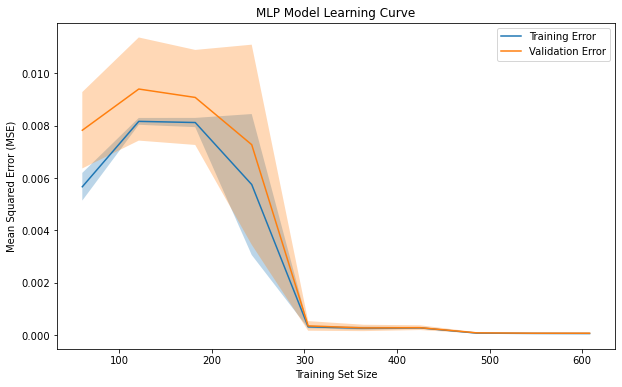

In [212]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3)
plt.plot(train_sizes, test_scores_mean, label='Validation Error')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.3)

plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MLP Model Learning Curve')
plt.legend()
plt.show()

In [213]:
# Getting a table
train_sizes, train_scores, test_scores = learning_curve(
    mlp_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of training and testing scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Print the values
print("Training Set Size\tTraining Error\tValidation Error")
for i in range(len(train_sizes)):
    print(f"{train_sizes[i]:.0%}\t\t\t{train_scores_mean[i]:.6f}\t\t{test_scores_mean[i]:.6f}")


Training Set Size	Training Error	Validation Error
6000%			0.005671		0.007829
12100%			0.008168		0.009403
18200%			0.008124		0.009082
24300%			0.005757		0.007278
30400%			0.000320		0.000355
36400%			0.000267		0.000278
42500%			0.000281		0.000288
48600%			0.000080		0.000090
54700%			0.000068		0.000077
60800%			0.000064		0.000076


From the table and the plot, the learning curve illustrates solid model performance with rapid convergence and minimal overfitting. Based on the trend, further increases in training data may yield minor improvements.

Training error reduces at a faster rate than validation error as expected. The gap between the two remains small throughout.
No clear overfitting is evident even at 100% training size fraction as validation error remains low.

## Web Application

The following are the lines of code that went into creating our web application. These were done using a PyCharm IDE and the output along with evaluation of results are shared in the project report.

#### Flask 'SettleIn' App Program (Python)

In [ ]:
from flask import Flask, render_template, request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np

app = Flask(__name__)


@app.route('/')
def index():
    return render_template('settle index.html')


@app.route('/process_data', methods=['POST'])
def process_data():
    try:
        # Retrieve data from the form
        first_name = request.form.get('first_name')
        ethnicity = request.form.get('ethnicity')

        # Get selected priorities from the form
        priority1 = request.form.get('priority1')
        priority2 = request.form.get('priority2')
        priority3 = request.form.get('priority3')
        priority4 = request.form.get('priority4')

        # Map user's ethnicity to corresponding column
        user_ethnicity_column = f"{ethnicity}"

        # Feature Engineering with Weighted Priorities
        weights = {
            priority1: 0.4,
            priority2: 0.3,
            priority3: 0.2,
            priority4: 0.1,
        }

        # Print the variables
        print("First Name:", first_name)
        print("Ethnicity:", ethnicity)
        print("Priority 1:", priority1)
        print("Priority 2:", priority2)
        print("Priority 3:", priority3)
        print("Priority 4:", priority4)

        # Initialize dictionary to build DataFrame
        prefs_dict = {}

        # Add weighted priorities
        selected_qualities = [priority1, priority2, priority3, priority4]
        for quality in selected_qualities:
            prefs_dict[quality] = weights[quality]

        # Conditionally add ethnicity
        if "High Ethnic Population" in prefs_dict:
            new_key = ethnicity
            prefs_dict[new_key] = prefs_dict.pop("High Ethnic Population")

        # Create DataFrame
        user_df = pd.DataFrame(prefs_dict, index=[0])

        print("user_df:")
        print(user_df)

        # Load and clean the data
        cleaned = pd.read_csv(r'C:\Users\HP\PycharmProjects\SettleIn\venv\10merge_final.csv')
        df = cleaned.copy()
        column_rename_dict = {
            'Crime Rate (%)': 'Low Crime Rate',
            'Unemployed (%)': 'Low Unemployment Rate',
            'COL Index': 'Low Average Cost of Living',
            'Rent Index': 'Low Average Rent',
            'IMD (Average Score)': 'Low IMD Score'
        }
        df.rename(columns=column_rename_dict, inplace=True)

        # Get first 5 rows of df
        print(df.head())

        # Get columns common to both DataFrames
        common_cols = user_df.columns.intersection(df.columns)

        print("Common_cols:")
        print(common_cols)

        # Add these lines to your code before the common_cols calculation
        print("Columns in user_df:")
        print(user_df.columns)

        print("Columns in df:")
        print(df.columns)

        # Include numeric columns
        # numeric_cols = df.select_dtypes('number').columns
        selected_cols = list(common_cols) + ['Name', 'City']

        # Subset those columns + additional needed ones
        selected_df = df[selected_cols].copy()

        print(selected_df.head())
        print(selected_df.shape)
        print(selected_df.info())

        # Normalize numeric columns
        numeric_cols = selected_df.select_dtypes('number').columns
        selected_df[numeric_cols] = (selected_df[numeric_cols] - selected_df[numeric_cols].min()) / (
                selected_df[numeric_cols].max() - selected_df[numeric_cols].min())

        print("Normalized DataFrame:")
        print(selected_df[numeric_cols])
        print(selected_df[numeric_cols].info())

        # Calculate score
        scores = []

        for index, row in selected_df.iterrows():
            score = 0
            for col in common_cols:
                weight = user_df.at[0, col]
                value = row[col]
                score += weight * value

            scores.append(score)

        selected_df['Composite Score'] = scores

        print("DataFrame with Composite Score:")
        print(selected_df[['Name', 'City', 'Composite Score']])

        # Print selected_df[numeric_cols] before the train/test split
        print("Before train/test split:")
        print(selected_df[numeric_cols])

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(selected_df[numeric_cols], selected_df['Composite Score'],
                                                            test_size=0.2, random_state=42)

        # Print X_train and y_train to debug
        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)

        # Use the best hyperparameters obtained from grid search
        best_params = {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 0.01,
                       'learning_rate': 'adaptive'}

        # Initialize the MLP model with the best hyperparameters
        best_mlp_model = MLPRegressor(**best_params, random_state=42)

        # Train the MLP model
        best_mlp_model.fit(X_train, y_train)

        # Make predictions
        user_recommendations = best_mlp_model.predict(selected_df[numeric_cols])

        # Normalize predictions
        user_recommendations = user_recommendations.reshape(-1, 1)
        scaler = MinMaxScaler()
        user_recommendations = scaler.fit_transform(user_recommendations)
        user_recommendations = user_recommendations.flatten()

        # Get top 5 recommendation indices
        sorted_idx = user_recommendations.argsort()[::-1][:5]

        # Get top 5 rows
        cols = ['Name', 'City', 'Composite Score']
        top_recommendations = selected_df[cols].iloc[sorted_idx]

        # Add rank and percentage match columns
        top_recommendations['Rank'] = range(1, len(top_recommendations) + 1)
        top_recommendations['Percentage Match'] = (user_recommendations[sorted_idx] * 100).round(2)

        # Sort and format
        top_recommendations = top_recommendations.sort_values('Percentage Match', ascending=False)
        top_recommendations = top_recommendations.drop(columns=['Composite Score'])

        # Create a DataFrame for priority choices
        priority_data = {'Priority': ['1st Priority', '2nd Priority', '3rd Priority', '4th Priority'],
                         'Choice': [priority1, priority2, priority3, priority4]}
        priority_df = pd.DataFrame(priority_data)

        # Create an HTML table for priority choices
        priority_table_html = priority_df.to_html(index=False, classes='table table-striped')

        # Greeting text with priority choices
        greeting_text = f"Hi {first_name},\n\nThese were your selections;\n\n{priority_table_html}\nWe are proud to share the following ward suggestions as the best fit given your entry. Congrats!\n"

        # Render tables
        priority_table_html = priority_df.to_html(index=False, classes='table table-striped')
        recommendations_table_html = top_recommendations.to_html(classes='table table-striped')

        # Pass the helpful text and tables to the template
        return render_template('settle index.html', greeting=greeting_text, priority_table=priority_table_html,
                               recommendations=recommendations_table_html)


    except Exception as e:
        return render_template('error.html', error=str(e))


if __name__ == '__main__':
    app.run(debug=True)

#### HTML Script for Home Page

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
  <meta http-equiv="Content-Type" content="text/html; charset=UTF-8"/>
  <meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1.0"/>
  <title>Settle In</title>

  <!-- CSS  -->
  <link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
  <link href="./static/css/materialize.css" type="text/css" rel="stylesheet" media="screen,projection"/>
  <link href="./static/css2/style.css" type="text/css" rel="stylesheet" media="screen,projection"/>
</head>

<body>
  <nav class="light-blue lighten-1" role="navigation">
    <div class="nav-wrapper container">
      <a id="logo-container" href="#" class="brand-logo">
        <img src="C:/Users/HP/PycharmProjects/SettleIn/venv/logo.jpeg">
      <ul class="right hide-on-med-and-down">
        <li><a href="#">Navbar Link</a></li>
      </ul>

      <ul id="nav-mobile" class="sidenav">
        <li><a href="#">Navbar Link</a></li>
      </ul>
      <a href="#" data-target="nav-mobile" class="sidenav-trigger"><i class="material-icons">menu</i></a>
    </div>
  </nav>

  <div class="section no-pad-bot" id="index-banner">
    <div class="container">
      <br><br>
      <h1 class="header center orange-text">Settle In</h1>
      <div class="row center">
        <h5 class="header col s12 light">Looking for where to settle? We're here to help!<br></h5>
      </div>

      <form action='/process_data' method="POST" onsubmit="return validateForm();">
          <!-- Layer 1: User's First Name -->
          <div class="row">
            <div class="input-field col s12">

              <input id="first_name" name='first_name' type="text" class="validate" placeholder="Kindly enter your name">
            </div>
          </div>

          <!-- Layer 2: Ethnicity Selection -->
          <div class="row" style="display:flex;gap:2rem">
            <div class="row" style="width:55%">
              <div class="input-field col s12" style="margin-top:0">
                <div>What's your ethnicity?</div>

                <!-- List of ethnic groups with radios -->

                  <!-- First Column -->
                  <div class="col s12" style="display:flex; flex-wrap:wrap; margin-top: 1.5rem">
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="White British"/>
                      <span>White British</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Other White"/>
                      <span>Other White</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="White Irish"/>
                      <span>White Irish</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Black African"/>
                      <span>Black African</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Black Caribbean"/>
                      <span>Black Caribbean</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Other Black"/>
                      <span>Other Black</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Pakistani"/>
                      <span>Pakistani</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Chinese"/>
                      <span>Chinese</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Indian"/>
                      <span>Indian</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Bangladeshi"/>
                      <span>Bangladeshi</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Other Asian"/>
                      <span>Other Asian</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Arab"/>
                      <span>Arab</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Mixed White and Asian"/>
                      <span>Mixed White and Asian</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Mixed White and Black Caribbean"/>
                      <span>Mixed White and Black Caribbean</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Mixed White and Black African"/>
                      <span>Mixed White and Black African</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Other Mixed"/>
                      <span>Other Mixed</span>
                    </label>
                    <label style="width:50%">
                      <input type="radio" name="ethnicity" value="Other Ethnic Group"/>
                      <span>Other Ethnic Group</span>
                    </label>
                  </div>


              </div>
            </div>

            <!-- Layer 3: Qualities Selection -->
            <div class="row" style="width:45%">
              <div>4 Qualities of your new Community in order of Priority</div>

              <!-- Priority 1 Dropdown -->
              <div class="input-field col s12">
                <div for="priority1">Priority 1</div>
                <select id="priority1" class="qualities-dropdown" name="priority1">
                  <option value="" disabled selected>Select an option</option>
                  <option value="High Ethnic Population">High Ethnic Population</option>
                  <option value="Low Crime Rate">Low Crime Rate</option>
                  <option value="Low Unemployment Rate">Low Unemployment Rate</option>
                  <option value="Low Average Cost of Living">Low Average Cost of Living</option>
                  <option value="Low Average Rent">Low Average Rent</option>
                  <option value="Low IMD Score">Low IMD Score</option>
                </select>
              </div>

              <!-- Priority 2 Dropdown -->
              <div class="input-field col s12">
                <div for="priority2">Priority 2</div>
                <select id="priority2" class="qualities-dropdown"  name="priority2" disabled>
                  <option value="" disabled selected>Select an option</option>
                  <option value="High Ethnic Population">High Ethnic Population</option>
                  <option value="Low Crime Rate">Low Crime Rate</option>
                  <option value="Low Unemployment Rate">Low Unemployment Rate</option>
                  <option value="Low Average Cost of Living">Low Average Cost of Living</option>
                  <option value="Low Average Rent">Low Average Rent</option>
                  <option value="Low IMD Score">Low IMD Score</option>
                </select>
              </div>

              <!-- Priority 3 Dropdown -->
              <div class="input-field col s12">
                <div for="priority3">Priority 3</div>
                <select id="priority3" class="qualities-dropdown"  name="priority3" disabled>
                  <option value="" disabled selected>Select an option</option>
                  <option value="High Ethnic Population">High Ethnic Population</option>
                  <option value="Low Crime Rate">Low Crime Rate</option>
                  <option value="Low Unemployment Rate">Low Unemployment Rate</option>
                  <option value="Low Average Cost of Living">Low Average Cost of Living</option>
                  <option value="Low Average Rent">Low Average Rent</option>
                  <option value="Low IMD Score">Low IMD Score</option>
                </select>
              </div>

              <!-- Priority 4 Dropdown -->
              <div class="input-field col s12">
                <div for="priority4">Priority 4</div>
                <select id="priority4" class="qualities-dropdown"  name="priority4" disabled>
                  <option value="" disabled selected>Select an option</option>
                  <option value="High Ethnic Population">High Ethnic Population</option>
                  <option value="Low Crime Rate">Low Crime Rate</option>
                  <option value="Low Unemployment Rate">Low Unemployment Rate</option>
                  <option value="Low Average Cost of Living">Low Average Cost of Living</option>
                  <option value="Low Average Rent">Low Average Rent</option>
                  <option value="Low IMD Score">Low IMD Score</option>
                </select>
              </div>
            </div>

            <script>
              // JavaScript to update dropdowns based on selected options
              const dropdowns = document.querySelectorAll('.qualities-dropdown');

              dropdowns.forEach((dropdown, index) => {
                dropdown.addEventListener('change', () => {
                  // Remove selected option from other dropdowns
                  dropdowns.forEach((otherDropdown, otherIndex) => {
                    if (otherIndex !== index) {
                      const selectedOption = dropdown.value;
                      const optionToRemove = Array.from(otherDropdown.options).find(option => option.value === selectedOption);
                      if (optionToRemove) {
                        otherDropdown.remove(optionToRemove.index);
                      }
                    }
                  });

                  // Enable the next dropdown if a selection is made
                  if (dropdown.value !== '') {
                    const nextDropdown = dropdowns[index + 1];
                    if (nextDropdown) {
                      nextDropdown.disabled = false;
                    }
                  }

                  // Trigger the event to update dropdowns in Layer 4
                  const updateEvent = new Event('updateDropdownsLayer4');
                  document.dispatchEvent(updateEvent);
                });
              });
            </script>
        </div>
          <!-- Submit Button-->
          <div class="row center">
            <button type="submit" class="btn-large waves-effect waves-light orange" id="submitButton">See the Best Fit!</button>
          </div><br><br>

          <!-- Recommendations Section -->
          <div>
              <!-- Display the priorities table -->
              <h2>Priority Choices</h2>
              <p>{{ greeting | safe }}</p>

              <!-- Display the recommendations table -->
              <h2>Recommendations</h2>
              <p>{{ recommendations | safe }}</p>
          </div>

    </div>
  </div>

  <!-- Add these elements for error messages -->
  <div id="nameError" class="red-text"></div>
  <div id="ethnicityError" class="red-text"></div>
  <div id="qualitiesError" class="red-text"></div>

    <footer class="page-footer orange">
    <div class="container">
      <div class="row">
        <div class="col l12 s6">
          <h6 class="white-text">About the Project</h6>
          <p class="grey-text text-lighten-4">SettleIn modernizes immigrant transition experiences by making neighborhood selection effortless. My interactive query generator elicits user priorities then maps these to best-fit locations utilizing inventive machine learning methodology</p>
      </div>
    </div>
    <div class="footer-copyright">
      <div class="container">
      Made by <a class="orange-text text-lighten-3" href="http://materializecss.com">Materialize</a>
      </div>
    </div>
  </footer>

  <!-- Scripts-->
  <script src="https://code.jquery.com/jquery-2.1.1.min.js"></script>
  <script src="./js/materialize.js"></script>
  <script src="./js/init.js"></script>

<script>
  function validateForm() {
    console.log('validateForm function called');

    // Reset error messages
    document.getElementById('nameError').innerHTML = '';
    document.getElementById('ethnicityError').innerHTML = '';
    document.getElementById('qualitiesError').innerHTML = '';

    // Layer 1 validation (Name)
    const firstName = document.getElementById('first_name').value;
    if (firstName.trim() === '') {
      document.getElementById('nameError').innerHTML = 'Please enter your name.';
      return false; // Stop form submission
    }

    // Layer 2 validation (Ethnicity)
    const selectedEthnicity = document.querySelector('input[name="ethnicity"]:checked');
    if (!selectedEthnicity) {
      document.getElementById('ethnicityError').innerHTML = 'Please select your ethnicity.';
      return false; // Stop form submission
    }

    // Layer 3 validation (Qualities)
    const selectedQualities = document.querySelectorAll('.qualities-dropdown option:checked');
    if (selectedQualities.length !== 4) {
      document.getElementById('qualitiesError').innerHTML = 'Please select exactly 4 qualities.';
      return false; // Stop form submission
    }

    // Continue with form submission
    return true;
  }
</script>
</body>
</html>